In [2]:
# Import libraries 
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
from bokeh.io import output_file, show, output_notebook, curdoc, reset_output
from bokeh.plotting import figure
from bokeh.palettes import Category20, inferno, RdYlGn
from bokeh.models import FactorRange, Button, ColumnDataSource, Legend, LegendItem, Slider, VBar, Plot, Panel, Select, CustomJS, WheelZoomTool, PanTool, ResetTool
from bokeh.layouts import column, row, widgetbox, layout
from bokeh.models.widgets import Div
import matplotlib.pyplot as plt
import seaborn as sb
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, PreText, CheckboxButtonGroup, WheelZoomTool
from bokeh.palettes import Spectral6, brewer
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Paragraph,
                          Legend, LegendItem, Label,FactorRange, Div)
from bokeh.models.widgets import Panel, Tabs
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.transform import jitter
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    NumeralTickFormatter,
    ColorBar,
    FactorRange
)
from bokeh.plotting import figure
from bokeh.palettes import BuPu
import holoviews as hv 
#hv.extension('bokeh')
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.stats import spearmanr, kendalltau
from scipy import stats


In [3]:
# Data import 
data2 = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\crash_data.csv",low_memory=False)

# Explainer notebook

# Motivation.
## - What is your dataset?

This project concerns traffic collisions in New York City in the period 2012-2020. [Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) used for this purpose is obtained from NYC open data.

The Motor Vehicle Collisions crash table consists of rows, each representing a crash event with further details. The Motor Vehicle Collisions data tables are based on police report (MV104-AN) documentations, which is required to be filled out for collisions where someone is injured, killed, or a minimum of $1000 worth of damage is caused.

## - Why did you choose this/these particular dataset(s)?

First, after looking at different freely available databases it was decided to focus on the NYC open data due to in general a large quantity of data and a good level of detail. Secondly, information was found about the [NYC Vision Zero program](https://www1.nyc.gov/content/visionzero/pages/) where the ambition is to make a decline towards zero in fatalities caused by traffic collisions. Parts of this NYC Vision Zero program was implemented in 2014 like speed reduction, and it would be interesting to investigate the effect of this program. To investigate the effect of Vision Zero and in general to get an overview of traffical collisions, the Motor Vehicle Collisions Crashes dataset has been used for this work.

## - What was your goal for the end user's experience?

An interactive dashboard has been developed, focusing on collisions in NYC, to make it possible for the reader to interact and explore data in the designed models based on the Motor Vehicle Collisions Crashes dataset from NYC. The interactivity is stimulating and the reader can use the interactive dashboard and identify trends, problematics and maybe draw conclusions from the otherwise quite large dataset of about 1.5M rows, each representing a crash event.  

# Basic stats.
## - Write about your choices in data cleaning and preprocessing
We start of by cleaning and preparing our data which consists of over 1.67M rows with a total of 29 columns.

In [4]:
df_crash = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\Motor_Vehicle_Collisions_-_Crashes.csv", low_memory = False)
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%m/%d/%Y") )
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M") )

### Time-series
As we are dealing with data that ranges from mid 2012 to now, we want to make sure that there are not any missing gaps throughout this period of time.

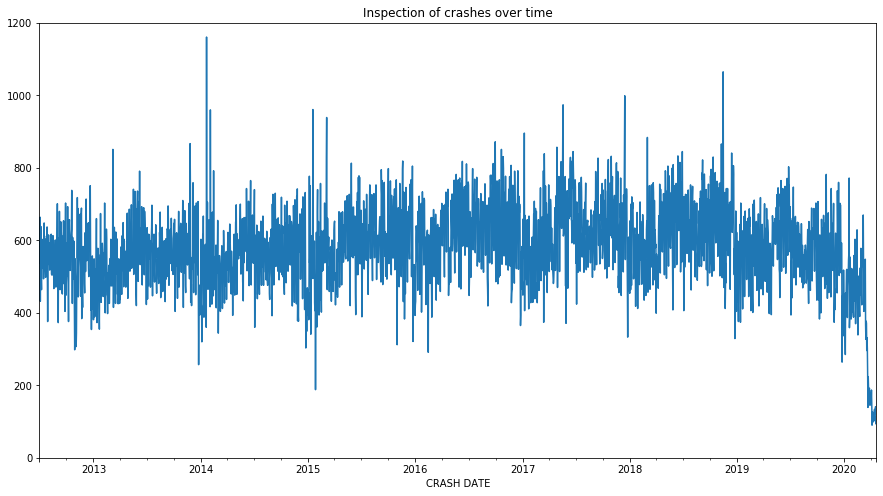

In [5]:
#Checking the range of our data
df_crash.groupby('CRASH DATE').size().plot(figsize=(15,8),ylim = (0,1200), title = "Inspection of crashes over time" );

There appear to be no gaps (missing periods) from mid 2012 to 2020. But since we will be taking a look at the change of crashes from year to year, we will limit our data to consist of only dates ranging from 2013 to 2019. 

In [6]:
df_crash = df_crash.loc[((df_crash['CRASH DATE'].dt.year !=2020) & (df_crash['CRASH DATE'].dt.year != 2012))]

### Filling out missing values
A large part of our data was missing information about which borough the crash took place in. This information is however obtainable by looking up the coordinates, if given. To do this, we made use of the package 'geopy' and withdrew as many zip codes as we could, followed by merging them with a list of all zip codes and their respective borough.

Almost 320,000 rows were missing information about the Borough, while both latitude and longitude were present.

In [7]:
df_crash.loc[(df_crash['BOROUGH'].isna() & (df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna()))].shape

(318827, 29)

**Warning**! The following code is looking up each unique pair of coordinates and takes approximately 6 hours.

In [ ]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

df_latlong = df_crash.loc[(df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna())].copy()
df_latlong['latlong'] = list(zip(df_latlong['LATITUDE'],df_latlong['LONGITUDE']))
locator = Nominatim(user_agent='myGeocoder', timeout= 50000)
dict_geocode = {}
address = df_latlong['latlong'].unique()
for x in address:
    if x not in dict_geocode:
        dict_geocode[x] = []
    location = locator.reverse(x)
    if 'address' in location.raw:
        if 'postcode' in location.raw['address']:
            dict_geocode[x].append(location.raw['address']['postcode'])

df_crash['address'] = list(zip(df_crash['LATITUDE'],df_crash['LONGITUDE']))
df_crash['postcode'] = df_crash['address'].map(dict_geocode)

df_zipcode = pd.read_csv("C:\\Users\Dude\Desktop\zip_codes2.csv")
df_zipcode['postcode'] = df_zipcode['postcode'].astype('str')

dict_zipcode = df_zipcode.set_index('postcode')['borough']
df_crash['district']=df_crash['postcode'].map(dict_zipcode)
df_crash['district']=df_crash['district'].str.upper()

#Replacing missing values in 'Borough' with the ones we've just retrived.
df_crash['BOROUGH'].loc[(df_crash['BOROUGH'].isna() & df_crash['district'].notna())] = df_crash['district']

#Saving our new dataset - to prevent running above code again.
df_crash.to_csv(r'C:\\Users\Dude\Desktop\crash_data.csv', index=False)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import datetime as dt
# We then have our new dataset - which we load again to refrain from running above code
df_crash = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\crash_data.csv",low_memory=False)
df_crash["CRASH DATE"] = df_crash["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_crash["CRASH TIME"] = df_crash["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))

And that is about it. We made sure that there were no gaps from 2013 to 2019, and filled out over 300,000 missing values for 'Borough' to get the most out of our analysis. There are still many things to consider each time we include a variable, but in each scenario throughout this project, we accommodate our needs for that exact analysis, whether removing missing values or taking them into account.

# Data Analysis

## - **Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis**.
## - **Describe your data analysis and explain what you've learned about the dataset.**
## - **If relevant, talk about your machine-learning.**

 The following section describes the process for making this data analysis. A short overview of the content is provided below: 
 
   - Preliminary analysis to get an overview of the data.
   - Overview of deaths and injuries in relation to traffic collisions.
   - Contributing factors. 
   - Machine learning.     
    

#### - Preliminary analysis to get an overview of the data.  

All 'NaN' values in the BOROUGH variable have been replaced with 'UNKONWN', in that way the number of collisions are totally represented. New columns have been added to the dataset like year, month, weekday and hour using the datetime module.    

In [13]:
# Adding a new column which contains year from CRASH DATE variable
data2 = df_crash.copy()
data2['year'] = data2['CRASH DATE'].dt.year
data2['month'] = data2['CRASH DATE'].dt.month
data2['hour'] = data2['CRASH TIME'].dt.hour
data2['weekday']= data2['CRASH DATE'].dt.day_name()

# Replacing nan values by 'UNKNOWN' in BOROUGH column
data2.BOROUGH.fillna('UNKNOWN', inplace=True)

The number of collisions per borough for the period 2013-2019 has been examined using bokeh plots:

In [14]:
output_notebook();

# List of boroughs: 
borough =['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX',
       'STATEN ISLAND']

# list of years
years = ['{}'.format(i) for i in data2['CRASH DATE'].dt.year.sort_values(ascending=True).unique()]

# data
data2['year_string'] = data2['CRASH DATE'].dt.year.astype(str)
crash_data_p11 = data2.groupby(['year_string','BOROUGH']).size().unstack().copy()
source_p11 = ColumnDataSource(crash_data_p11)

colors = brewer['YlGnBu'][6]

# figure layout 
p_11 = figure(x_range=FactorRange(*years), y_range= (0,250000), plot_height=300, plot_width=600, title=" A) Collisions from 2013-2019",
           x_axis_label = 'Year', y_axis_label = 'Number of collisions',
           toolbar_location=None, tools="hover", tooltips="$name: @$name")
p_11.yaxis[0].formatter = NumeralTickFormatter(format='0')

p_11.title.text_font_size = '12pt'
p_11.xaxis.axis_label_text_font_size = "8pt"
p_11.yaxis.axis_label_text_font_size = "8pt"

bar ={} 
items = []

# Add data into figure 
v = p_11.vbar_stack(borough, x='year_string', width=0.8, color=colors, source=source_p11, muted_alpha= 0.1, muted=False)

legend = Legend(items=[(x, [v[i]]) for i, x in enumerate(borough)], location=(0, 30))
p_11.add_layout(legend, 'left')


p_11.y_range.start = 0
p_11.x_range.range_padding = 0.1
p_11.xgrid.grid_line_color = None
p_11.axis.minor_tick_line_color = None
p_11.outline_line_color = None

show(p_11)

Loading BokehJS ...

Figure A) shows the number of collisions from 2013-2019. All boroughs are divided into distinctive colors described in the legends left of the figure, providing a more detailed overview. A toolbox occurs when hovering the cursor on the colored arrays in the bar chart. Brooklyn and Queens in general seems to be dominating in the number of collisions but these two boroughs are also some of the largest in areal size and may hold a higher density of citizens.  

Looking at the graph there is an increase in the number of collisions from 2013 to 2016. The following three years the number of collisions are steady and from 2018-2019 the number of collisions has decreased. 

It is also worth noticing the number of collisions for UNKNOWN decreases markedly in the period 2016-2019. This decrease might explain why boroughs such as BROOKLYN and QUEENS increases simultaneously in number of collisions.    

In relation to the implementation of the Vision Zero program which started in 2014, it does not seem to have had an impact on the total number of collisions the following years.  


In [15]:
# dataset
crash_data_p12 = data2.groupby(['month','BOROUGH']).size().unstack().copy()

source_p12 = ColumnDataSource(data = crash_data_p12)

legend_list = data2['BOROUGH'].unique()
colors_list = brewer['YlGnBu'][6]

# figure  layout
p_12 = figure(plot_width=600, plot_height=300, title="B) Collisions per borough every month from 2013-2019",
           x_axis_label = 'Month', y_axis_label = 'Number of collisions',
           toolbar_location=None)


p_12.title.text_font_size = '10pt'
p_12.xaxis.axis_label_text_font_size = "8pt"
p_12.yaxis.axis_label_text_font_size = "8pt"

legend_it = []

# Add data into figure
for (indx,i),color in zip(enumerate(legend_list),colors_list):
    my_plot = p_12.line(x='month', y=i, color= color, line_width=2.0, source=source_p12)
    legend_it.append((i, [my_plot]))
    
legend = Legend(items=legend_it, location=(0, 30))
p_12.add_layout(legend, 'left')

show(p_12)

Figure B) above shows the number of collisions per borough every month from 2013-2019. The number of collisions are lower for the boroughs during the winter months, increases during the spring and seems to reach a plateu until the end of autumn. This overall tendency might be due to higher activity in the warmer months like in general more people venturing outside, bicycles and tourists etc. Brooklyn and Queens are where the most collisions happen. 

In [16]:
colors = brewer['YlGnBu'][6]

# list of boroughs and weekdays 
borough =['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX','STATEN ISLAND']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# dataset 
crash_data_p21 = data2.groupby(['weekday','BOROUGH']).size().unstack().reset_index().copy()
source_p21 = ColumnDataSource(data=crash_data_p21)

bar ={} 
items = []

# figure layout
p_21 = figure(x_range=FactorRange(*weekdays), y_range= (0,300000), plot_height=300, plot_width=600, title=" C) Collisions on weekdays from 2013-2019",
           x_axis_label = 'Weekday', y_axis_label = 'Number of collisions',
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p_21.title.text_font_size = '10pt'
p_21.xaxis.axis_label_text_font_size = "8pt"
p_21.yaxis.axis_label_text_font_size = "8pt"

# Add data into figure
v = p_21.vbar_stack(borough, x='weekday', width=0.8, color=colors, source=source_p21)

# define legend 
legend = Legend(items=[(x, [v[i]]) for i, x in enumerate(borough)], location=(0, 30))
p_21.add_layout(legend, 'left')

p_21.yaxis[0].formatter = NumeralTickFormatter(format='0')
p_21.y_range.start = 0
p_21.x_range.range_padding = 0.1
p_21.xgrid.grid_line_color = None
p_21.axis.minor_tick_line_color = None
p_21.outline_line_color = None
p_21.xaxis.major_label_orientation = 'vertical'

show(p_21)

Figure C) shows the number of collisions per weekday from 2013-2019. The number of collisions are steady from monday to thursday, peaks friday and declines during the weekend. The peak on friday could be due to high activity from people going out in the night, visiting relatives outside town etc. The decline during the weekend could maybe be explained from the missing rush hours seen in the normal weekdays.    

In [11]:
# dataset 
crash_data_p22 = data2.groupby(['hour','BOROUGH']).size().unstack().copy()
source_p22 = ColumnDataSource(data = crash_data_p22)

# String boroughs and colors 
legend_list = ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX','STATEN ISLAND'] 
colors_list = brewer['YlGnBu'][6]

# figure layout
p_22 = figure(plot_width=600, plot_height=300, title="D) Collisions per borough every hour from 2013-2019",
           x_axis_label = 'Hour', y_axis_label = 'Number of collisions',
           toolbar_location=None)

p_22.title.text_font_size = '10pt'
p_22.xaxis.axis_label_text_font_size = "8pt"
p_22.yaxis.axis_label_text_font_size = "8pt"

legend_it = []

# Add data into figure
for (indx,i),color in zip(enumerate(legend_list),colors_list):
    my_plot = p_22.line(x='hour', y=i, color= color, line_width=2.0, source=source_p22)
    legend_it.append((i, [my_plot]))

# define legend
legend = Legend(items=legend_it, location=(0, 30))
p_22.add_layout(legend, 'left')

show(p_22)


Figure D) shows the number of collisions per borough per hour from 2013-2019. The number of collisions increases markedly in the rush hours around 8:00 and again around 16:00. In general there are also an increasing tendency in the time interval from 8:00 to 16:00 which probably can be explained by an increase in professional driving besides the normal weekday traffic. Again it can be seen that Brooklyn and Queens are where the most collisions happen.   

#### - Overview of deaths and injuries in relation to traffic collisions. 

Bar charts and a table have been made to give an overview of the number of fatalities and injuries related to traffic collisions:

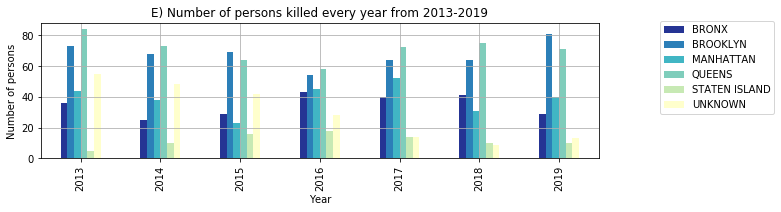

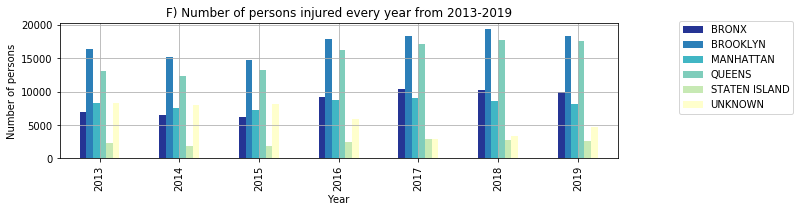

,NUMBER OF PERSONS KILLED,NUMBER OF PERSONS INJURED
year,,
2013,297.0,55125.0
2014,262.0,51223.0
2015,243.0,51358.0
2016,246.0,60316.0
2017,256.0,60656.0
2018,230.0,61940.0
2019,244.0,61379.0


In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,2.5),sharex=True)

# string years and colors
years = data2['year'].unique()
colors = brewer['YlGnBu'][6]

# dataset (Number of persons killed) 
crash_killed = data2[['BOROUGH','year','NUMBER OF PERSONS KILLED']].groupby(['BOROUGH','year'])['NUMBER OF PERSONS KILLED'].sum().reset_index(name="Antal")
# plot
crash_killed.pivot('year','BOROUGH', 'Antal').plot(kind='bar', color=colors,ax=ax, grid=True).plot(kind='bar', color=colors,ax=ax, grid=True)
plt.title('E) Number of persons killed every year from 2013-2019', fontsize = 12)
plt.setp(ax,xlabel = 'Year', ylabel = 'Number of persons')

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

fig, ax = plt.subplots(1,1,figsize=(10,2.5),sharex=True)

# dataset (Number of persons injured)
crash_injured = data2[['BOROUGH','year','NUMBER OF PERSONS INJURED']].groupby(['BOROUGH','year'])['NUMBER OF PERSONS INJURED'].sum().reset_index(name="Antal")
crash_injured.pivot('year','BOROUGH', 'Antal').plot(kind='bar', color=colors,ax=ax, grid=True).plot(kind='bar', color=colors,ax=ax, grid=True)
plt.title('F) Number of persons injured every year from 2013-2019', fontsize = 12)
plt.setp(ax,xlabel = 'Year', ylabel = 'Number of persons')

ax.legend(bbox_to_anchor=(1.1, 1.05))

plt.show()

# table containing the sum of persons killed and sum of persons injured
var_list = ['NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']

table_killed_injured = data2[['year','NUMBER OF PERSONS KILLED', 'NUMBER OF PERSONS INJURED']].groupby(['year'])[var_list].sum().copy()
table_killed_injured

The figures E) and F) above shows the number of persons killed or injured in a traffic collision in the different boroughs from 2013-2019. All boroughs are divided into distinctive colors described in the legends right of the figures, providing a more detailed overview. Brooklyn and Queens are where most people are killed or injured in traffic collisions. The table above shows the total number of persons killed and the total number of persons injured in the period 2013-2019.  

In relation to the implementation of the Vision Zero program which started in 2014, aiming to reduce persons killed in the traffic, it does seem that the number of persons killed in the traffic has been reduced. On the other hand the number of people getting injured has increased markedly making it hard to validate the efficiency of the Vision Zero program's implementation even though there is a small reduction in people dying in the traffic.


The number of pedestrians, cyclists and motorists fatalities has been examined using bokeh plots: 

In [20]:

# data
borough_data = data2.groupby(data2['BOROUGH']).agg({'NUMBER OF PERSONS KILLED': 'sum','NUMBER OF PERSONS INJURED':'sum', 
                                                                            'NUMBER OF PEDESTRIANS KILLED':'sum','NUMBER OF CYCLIST KILLED':'sum',
                                                                            'NUMBER OF MOTORIST KILLED':'sum','NUMBER OF PEDESTRIANS INJURED':'sum',
                                                                            'NUMBER OF CYCLIST INJURED':'sum','NUMBER OF MOTORIST INJURED':'sum'}).reset_index()
borough_data['PEDESTRIANS'] = borough_data['NUMBER OF PEDESTRIANS KILLED']
borough_data['CYCLISTS'] = borough_data['NUMBER OF CYCLIST KILLED']
borough_data['MOTORISTS'] = borough_data['NUMBER OF MOTORIST KILLED']
borough_data['KILLED'] = borough_data['NUMBER OF PEDESTRIANS KILLED'] + borough_data['NUMBER OF CYCLIST KILLED'] + borough_data['NUMBER OF MOTORIST KILLED']  
borough_data['INJURED'] = borough_data['NUMBER OF PEDESTRIANS INJURED'] + borough_data['NUMBER OF CYCLIST INJURED'] + borough_data['NUMBER OF MOTORIST INJURED']

# PLOT VBAR_STACK
# data source
source2_vbar = ColumnDataSource(data =borough_data)

colors = brewer['YlGnBu'][3]
boroughs = data2['BOROUGH'].unique()
road_user = ['PEDESTRIANS','CYCLISTS','MOTORISTS']

p_borough = figure(x_range = boroughs,plot_width=300, y_range = ((0,600)), plot_height=500, tools = "hover", tooltips = "$name: @$name", title="G) Distribution of road users",y_axis_label = 'Number of persons')
p_borough.vbar_stack(road_user, x='BOROUGH', width=0.3, color=colors, source=source2_vbar, legend_label =road_user);
p_borough.xaxis.major_label_orientation = 'vertical'
p_borough.legend.label_text_font_size = '5pt'
p_borough.legend.padding = 0

# JITTERPLOT - TIME
# data which contains number of persons killed. 
df_crash2 = data2.loc[data2['NUMBER OF PERSONS KILLED'] > 0]
df_crash2 = df_crash2[['CRASH TIME','weekday']]

source_map = ColumnDataSource(data = df_crash2)

DAYS = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

p2_hour_jitter = figure(plot_width=600, plot_height=250, y_range=DAYS, x_axis_type='datetime', 
           title="H) Collisions where a person is killed per hour in the period from 2013-2019")

p2_hour_jitter.circle(x='CRASH TIME', y=jitter('weekday', width=0.6, range=p2_hour_jitter.y_range),  source=source_map, alpha=0.4)

p2_hour_jitter.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter.x_range.range_padding = 0
p2_hour_jitter.ygrid.grid_line_color = None


layout = column(p_borough, p2_hour_jitter)
show(layout)

Figure G) shows the number of pedestrians, cyclists and motorists fatalities for every borough in the period from 2013-2019. Pedestrians, motorists and cyclists are divided into distinctive colors described in the legend in the right corner, providing a more detailed overview. A toolbox occurs when hovering the cursor on the colored arrays in the bar chart. 

Figure H) shows the distribution of fatal collisions for every weekday and hour in the period from 2013-2019. 

Brooklyn and Queeens are defintely the boroughs where most fatalities happen, pedistrians followed by motorists dominates in all boroughs. Figure H) may weakly indicate that fatal collisions occur more frequently in the afternoon hours and saturday/sunday also in the morning hours. 

        

In [21]:
# Only fatal collisions for every year and month: 
data_killed = data2.loc[data2['NUMBER OF PERSONS KILLED'] > 0].groupby(['year', 'month']).size().reset_index(name='Fatal_crashes').copy()

# All collisions for every year and month
data_crashes = data2.groupby(['year','month']).size().reset_index(name='Crashes').copy()

# Merge datasets
data_killed_crashes = pd.merge(data_killed, data_crashes, how='left', left_on=['year', 'month'], right_on=['year','month']).copy()

# Calculate frequency
data_killed_crashes['forhold'] = data_killed_crashes['Fatal_crashes']/data_killed_crashes['Crashes']

# Frequency average for every year: 
data_killed_avg = data_killed_crashes[['year','forhold']].groupby(['year']).mean().copy()

# Merge average data with frequency data 
data_killed_crashes2 = pd.merge(data_killed_crashes, data_killed_avg, how='left', left_on=['year'], right_on=['year']).copy()

# year and month to string
data_killed_crashes2['year'] = data_killed_crashes['year'].astype(str) 
data_killed_crashes2['month'] = data_killed_crashes['month'].astype(str) 

# set index to year,month
data_killed_crashes2.set_index(['year', 'month'], inplace=True)

source_killedcrash = ColumnDataSource(data=data_killed_crashes2)

# strings for figure 
years = ['{}'.format(i) for i in data2['CRASH DATE'].dt.year.sort_values(ascending=True).unique()]
months = ['{}'.format(i) for i in data2['CRASH DATE'].dt.month.sort_values(ascending=True).unique()]
x = [(y, m) for y in years for m in months]

# figure layout
p_fatal = figure(x_range=FactorRange(*x), y_range= (0,0.003), plot_height=300, plot_width=1000, title="I) The frequency of fatal collisions per month/year",
           toolbar_location=None, x_axis_label = 'month/year', y_axis_label = 'frequency',tools="hover", tooltips="@year_month: @forhold_x")

# Add frequency data into figure 
p_fatal.line(x='year_month', y='forhold_x', width=0.9, source=source_killedcrash, legend_label='Frequency')

# Add average data into figure 
p_fatal.line(x='year_month', y='forhold_y', width=0.9, source=source_killedcrash, legend_label='Average', line_color="green")

# Horizontal line, vision zero speed action 
p_fatal.line(x= [('2014','11'), ('2014','11')] ,y= [0,0.005], width=0.9, line_color="red", name='Vision zero', legend_label='Vision zero action')

p_fatal.y_range.start = 0
p_fatal.x_range.range_padding = 0
p_fatal.xaxis.major_label_orientation = 'vertical'

show(p_fatal)


Figur I) shows the frequency of fatal collisions in relation to total collisions for the given month and year.
The red vertical line indicates the period where speed reduction was implemented as a part of the Vision Zero program. The green line is the average of the frequencies for every year.

By comparing the amount of fatalities per crash, we are able to take into account a possible increase of traffic. If we assume a positive linear correlation between the amount of traffic and the amount of crashes, the decline since 2013 could indicate that the Vision Zero program has been somewhat successful.

#### - Contributing factors. 

An analysis of contributing factors has been made. There are 5 contributing factor columns in the dataset, these 5 columns have been merged into one column.  

In [24]:
# All contributing columns are chosen and renamed:
factor1 = data2[['CONTRIBUTING FACTOR VEHICLE 1']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 1':'CONTRIBUTING FACTOR'})
factor2 = data2[['CONTRIBUTING FACTOR VEHICLE 2']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 2':'CONTRIBUTING FACTOR'})
factor3 = data2[['CONTRIBUTING FACTOR VEHICLE 3']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 3':'CONTRIBUTING FACTOR'})
factor4 = data2[['CONTRIBUTING FACTOR VEHICLE 4']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 4':'CONTRIBUTING FACTOR'})
factor5 = data2[['CONTRIBUTING FACTOR VEHICLE 5']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 5':'CONTRIBUTING FACTOR'})

# The data are concatenated into one dataframe
frames = [factor1, factor2, factor3, factor4, factor5]
result = pd.concat(frames)

# all unspecified values are removed 
result2 = result.loc[result['CONTRIBUTING FACTOR'] != 'Unspecified']

# contributing factors which occurs 10000 times or more in the data are chosen:
result3 = result2.groupby('CONTRIBUTING FACTOR').size().sort_values(ascending=False).head(21).copy()
list_of_contributing  = result3.index.to_list()
result3


CONTRIBUTING FACTOR
Driver Inattention/Distraction    368956
Failure to Yield Right-of-Way     102918
Following Too Closely              97395
Other Vehicular                    77346
Backing Unsafely                   67050
Fatigued/Drowsy                    52594
Passing or Lane Usage Improper     48558
Turning Improperly                 46870
Passing Too Closely                42308
Unsafe Lane Changing               36824
Traffic Control Disregarded        29050
Driver Inexperience                28069
Lost Consciousness                 22257
Pavement Slippery                  19138
Reaction to Uninvolved Vehicle     16840
Unsafe Speed                       16741
Prescription Medication            16268
Alcohol Involvement                16065
Outside Car Distraction            12880
Oversized Vehicle                  11890
View Obstructed/Limited            11742
dtype: int64

The list above shows the top 21 contributing factors, which are contributing factors occuring 10000 times or more in the data. Driver inattention/distraction are definitely the contributing factor which occur most frequently in the data. Many of the contributing factors on the list could maybe be related to speed, therefore it could be interesting to do further exploration in the data knowing that the Vision Zero program implemented a speed reduction in November 2014.

Time intervals are added to data: 

In [25]:
# Doing a nested np.where(), default value equals to X
data2['timeinterval'] = np.where((data2.hour >= 0) & (data2.hour < 6), '0-5', 
                             np.where((data2.hour >= 6) & (data2.hour < 12), '6-11', 
                                      np.where((data2.hour >= 12) & (data2.hour < 18), '12-17',
                                               np.where((data2.hour >= 18) & (data2.hour < 24), '18-23','X' ))))

In [26]:
# All contributing factor columns and other relevant columns are chosen and renamed:
contribute1 = data2[['CONTRIBUTING FACTOR VEHICLE 1', 'year', 'COLLISION_ID','hour','month','timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 1':'CONTRIBUTING FACTOR'})
contribute2 = data2[['CONTRIBUTING FACTOR VEHICLE 2', 'year', 'COLLISION_ID','hour','month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 2':'CONTRIBUTING FACTOR'})
contribute3 = data2[['CONTRIBUTING FACTOR VEHICLE 3', 'year', 'COLLISION_ID', 'hour', 'month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 3':'CONTRIBUTING FACTOR'})
contribute4 = data2[['CONTRIBUTING FACTOR VEHICLE 4', 'year', 'COLLISION_ID', 'hour','month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 4':'CONTRIBUTING FACTOR'})
contribute5 = data2[['CONTRIBUTING FACTOR VEHICLE 5', 'year', 'COLLISION_ID', 'hour','month','timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 5':'CONTRIBUTING FACTOR'})

# The data are concatenated into one dataframe
frames_contribute = [contribute1, contribute2, contribute3, contribute4, contribute5]
result_contribute = pd.concat(frames_contribute)

# The data are filtered by the contributing factor list (list_of_contributing)
result_contribute_final = result_contribute[result_contribute['CONTRIBUTING FACTOR'].isin(list_of_contributing)] 

# The data are gouped into year, month and contributing factor
m = result_contribute_final.groupby([ 'year', 'month', 'CONTRIBUTING FACTOR']).size().unstack().reset_index().copy()

# Replace all nan values with 0
df_contri = m.fillna(0)

# join dataset with contributing factors and dataset with all crashes
data_contri_crashes = pd.merge(m, data_crashes, how='left', left_on=['year', 'month'], right_on=['year','month']).copy()

# year and month to string
data_contri_crashes['year'] = data_contri_crashes['year'].astype(str) 
data_contri_crashes['month'] = data_contri_crashes['month'].astype(str) 

# set index to year,month
data_contri_crashes.set_index(['year', 'month'], inplace=True)

# frequency contributing A (year yyyy, month x) / number of crashes (year yyyy, month x)
data_contri_crashes2 = data_contri_crashes.loc[:, 'Alcohol Involvement':'View Obstructed/Limited'].div(data_contri_crashes['Crashes'], axis=0).copy()

# Choosing a contributing factor
test = data_contri_crashes2[['Driver Inattention/Distraction']].rename(columns={'Driver Inattention/Distraction':'forhold_contri'}).copy()
source_contricrash = ColumnDataSource(data=test)

test2 = data_contri_crashes2[['Unsafe Lane Changing']].rename(columns={'Unsafe Lane Changing':'forhold_contri'}).copy()
source_contricrash2 = ColumnDataSource(data=test2)

In [27]:
# figure layout
p = figure(x_range=FactorRange(*x), y_range= (0,0.4), plot_height=300, plot_width=1000, title="J) The frequency for the contributing factor driver inattention/distraction" ,
           toolbar_location=None, x_axis_label = 'month/year', y_axis_label = 'frequency',tools="hover", tooltips="@year_month: @forhold_contri")

p2 = figure(x_range=FactorRange(*x), y_range= (0,0.1), plot_height=300, plot_width=1000, title="K) The frequency for the contributing factor Unsafe Lane Changing" ,
           toolbar_location=None, x_axis_label = 'month/year', y_axis_label = 'frequency',tools="hover", tooltips="@year_month: @forhold_contri")


# Add data into figure 
p.line(x='year_month', y='forhold_contri', width=0.9, source=source_contricrash, line_color="green", legend_label='frequency')
p2.line(x='year_month', y='forhold_contri', width=0.9, source=source_contricrash2, line_color="green", legend_label='frequency')


# Horizontal line, vision zero speed action 
p.line(x= [('2014','11'), ('2014','11')] ,y= [0,1], width=0.9, line_color="red", name='Vision zero', legend_label='Vision zero action')
p2.line(x= [('2014','11'), ('2014','11')] ,y= [0,1], width=0.9, line_color="red", name='Vision zero', legend_label='Vision zero action')

p.y_range.start = 0
p.x_range.range_padding = 0
p.xaxis.major_label_orientation = 'vertical'

p2.y_range.start = 0
p2.x_range.range_padding = 0
p2.xaxis.major_label_orientation = 'vertical'

layout= column(p,p2)
show(layout)


Figure J) and K) shows the frequency for the contributing factor "driver inattention/distraction" and "Unsafe Lane Changing" in relation to the total collisions for the given month and year. The frequency for "driver inattention/distraction" increases over time making up for about 13% of the total collisions in january 2013 to above 30% in december 2019. The red vertical line indicates the period where speed reduction was implemented as a part of the Vision Zero program.  

For some of the contributing factors like "Unsafe Lane Changing" or "Fatigued/Drowsy" from the data, it can be seen in the visualisation part that the frequency changes very drastically to zero or rises very drastically from zero at a certain time. This is depicted in figure K) above showing the frequency for the contributing factor "Unsafe Lane Changing" being close to zero in 2013 and about 3-4% in 2019. This maybe indicates errors in the data or an administrative change in how the contributing factors are annotated.

A correlation has been made in attempt to map the contributing factors in relation to time to reveal possible tendencies:

In [28]:
# The data are gouped into year, month and contributing factor
m2 = result_contribute_final.groupby(['year', 'month','CONTRIBUTING FACTOR']).size().unstack().reset_index().copy()

# Replace all nan values with 0 
df_contri2 = m2.fillna(0)

# The data are grouped into year and time interval 
timeinterval_data = data2[['year','month', 'timeinterval']].copy()
timeinterval_data2 = timeinterval_data.groupby(['year', 'month', 'timeinterval']).size().unstack().reset_index().copy()

# Merge datasets
data_timeinterval = pd.merge(df_contri2, timeinterval_data2, how='left', left_on=['year'], right_on=['year']).copy()

data_timeinterval2 = data_timeinterval[['Alcohol Involvement', 'Backing Unsafely','Driver Inattention/Distraction', 'Driver Inexperience',
       'Failure to Yield Right-of-Way', 'Fatigued/Drowsy',
       'Following Too Closely', 'Lost Consciousness', 'Other Vehicular',
       'Outside Car Distraction', 'Oversized Vehicle', 'Passing Too Closely',
       'Passing or Lane Usage Improper', 'Pavement Slippery',
       'Prescription Medication', 'Reaction to Uninvolved Vehicle',
       'Traffic Control Disregarded', 'Turning Improperly',
       'Unsafe Lane Changing', 'Unsafe Speed', 'View Obstructed/Limited','0-5', '6-11', '12-17', '18-23']]

# Investigate if pearson correlation can be used. Pearson correlation can only be used if the data have a normal distribution:
# Interpret the significance. Tests whether a sample differs from a normal distribution.

k, p = stats.normaltest(data_timeinterval2)
p

alpha = 0.05

for i in p:
    if i > alpha:
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")


The null hypothesis can be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected
The null hypothesis cannot be rejected


Much of the data is non-normally distributed and the null-hypothesis cannot be rejected. Instead of using the Pearson correlation test the Spearman Rank test is used which requires less strict criteria for the data.

In [29]:
# Spearman corr are calculated, data are ranked by year and month
spearmancorr = data_timeinterval.corr(method='spearman')
list_columns = spearmancorr.columns.to_list

# Relevant variables are chosen
spearmancorr_plot = spearmancorr.loc[['Alcohol Involvement', 'Backing Unsafely','Driver Inattention/Distraction', 'Driver Inexperience',
       'Failure to Yield Right-of-Way', 'Fatigued/Drowsy',
       'Following Too Closely', 'Lost Consciousness', 'Other Vehicular',
       'Outside Car Distraction', 'Oversized Vehicle', 'Passing Too Closely',
       'Passing or Lane Usage Improper', 'Pavement Slippery',
       'Prescription Medication', 'Reaction to Uninvolved Vehicle',
       'Traffic Control Disregarded', 'Turning Improperly',
       'Unsafe Lane Changing', 'Unsafe Speed', 'View Obstructed/Limited'], ['0-5', '6-11', '12-17', '18-23']]

In [31]:
# Correlation coefficients visualized in Heatmap: 

# Color maps:brewer['YlGnBu'][6]
colormap =cm.get_cmap("YlGnBu")
bokehpalette = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]

# Mapper, transposes a numerical value to a color. 
mapper = LinearColorMapper(palette=bokehpalette, low=spearmancorr.min().min(), high=spearmancorr.max().max())
x_range = FactorRange(factors=spearmancorr.columns.astype('str'))

timeinterval = list(spearmancorr_plot.columns.astype('str'))
contribution = list(spearmancorr_plot.index)

spearman_tabel2 = spearmancorr_plot.unstack().reset_index(name='antal')
#spearman_tabel22 = spearmancorr_plot.unstack().reset_index(name='antal')
source_corr = ColumnDataSource(spearman_tabel2)

# Fiugre layout
z = figure(title="L) Correlation between time interval and contribution factors", x_range=timeinterval, y_range=contribution
           , toolbar_location='below', toolbar_sticky=False, tools="hover", tooltips="Correlation: @antal")

# Add data into figure and map
z.rect(x='level_0', y='level_1', width=1, height=1, source=source_corr
       , fill_color={'field': 'antal', 'transform': mapper}, line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="6pt",
                     ticker=BasicTicker(desired_num_ticks=8),
                     formatter=NumeralTickFormatter(format="0.0"),
                      border_line_color=None, location=(0, 0),label_standoff=6)

z.add_layout(color_bar, 'right')
z.xaxis.axis_label = 'Time interval'
z.yaxis.axis_label = 'Contributing factor'
z.xaxis.major_label_orientation = 'vertical'

show(z)

Figure L) shows the correlation for the given contributing factor in relation to time for the total period 2013-2019. 
Colors indicate the strength of the correlation as depicted by the color scale on the right. The strongest correlations seems to be in the time interval 00:00 - 05:59 and like e.g. "Reaction to Uninvolved Vehicle", "Passing too closely", "Unsafe Lane Changing" and "Unsafe Speed", which seems to have a correlation coefficient close to 0.7 in these hours. This indicates that these types of contributing factors correlates well with time. 

### - Machine learning
Through machine learning, we want to see if the implementation of different initiatives would have any impact on the contributing factors of a crash. However, the implementations for Vision Zero are plenty, and it would be hard to distinguish one from another. We therefore chose to single out an initiative, that we believe would have an high impact on certain contributing factors for a crash. Reduction of speed. 

In the late 2014, New York City reduced the default speed limit to 25 MPH, and installed multiple speed cameras and speed bumps. ([Automated Speed Enforcement Program Report, 2014-2017](http://www.nyc.gov/html/dot/downloads/pdf/speed-camera-report-june2018.pdf)) We believe that the reduction of speed would have a high impact on crashes caused by a 'slippery pavement', while crashes caused by 'alcohol involvement' would be unaffected. 

This assumption is corresponding with our analysis on frequency of contributing factors from year to year, as well as the correlation analysis. 


In [40]:
spearmancorr.loc[['Alcohol Involvement'],['Pavement Slippery']]

,Pavement Slippery
Alcohol Involvement,-0.11631


By using the Random Forest Classifier model, we want to label the contributing factor of a crash, given a time (hour), location (borough) and information on whether the 'reduction of speed' had taken place or not.
We will use one hot encoding on the category 'Borough', to prevent our model from assuming any order between the 5 boroughs.

After implementing one hot encoding on 'borough' and assigning a value for '25mph' we end with the following dataframe consisting of 26687 rows.

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ML= df_crash[['CRASH DATE','CRASH TIME','BOROUGH','CONTRIBUTING FACTOR VEHICLE 1']]
ML2 = ML.loc[ML['CONTRIBUTING FACTOR VEHICLE 1'].isin(['Alcohol Involvement','Pavement Slippery'])].copy()
ML2['CRASH DATE'] = ML2['CRASH DATE'].dt.year
ML2['CRASH TIME'] = ML2['CRASH TIME'].dt.hour
ML2['25mph'] = 0
ML2.loc[(ML2['CRASH DATE'] != 2013) & (ML2['CRASH DATE'] != 2014),'25mph'] = 1 
ML2.rename(columns={'CRASH DATE':'Year','CRASH TIME':'Hour','CONTRIBUTING FACTOR VEHICLE 1':'Reason','BOROUGH':'Borough',},inplace=True)
ML2 = ML2.loc[ML2.Borough.notna()].copy()
ML2.drop(['Year'],axis=1,inplace=True)

crash_ML = pd.concat((ML2,pd.get_dummies(ML2.Borough)),1)
crash_ML.drop(['Borough'],axis=1,inplace=True)
crash_ML.columns = map(str.capitalize, crash_ML.columns)

combs = ML2.groupby(['Hour','Borough','25mph']).size().reset_index()
cols = ['Hour', '25mph', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten island','Reason']
crash2_ML = crash_ML.copy()
crash2_ML=crash2_ML[cols].copy()

#Splitting data into features (X) and labels (y)
X = crash_ML.drop(['Reason'],axis=1)
y = crash_ML['Reason']

#Randomly choosing 20% of the data as our test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#fitting our Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train);
pred_rfc=rfc.predict(X_test)

#Fraction of 'VEHICLE THEFT' labels in our testing data
print("Fraction of 'Pavement Slippery' in our testdata: ", y_test.value_counts()[0]/y_test.value_counts().sum())
#Fraction of 'VEHICLE THEFT' labels in our training data
print("Fraction of 'Pavement Slippery' in our trainingdata: ",y_train.value_counts()[0]/y_train.value_counts().sum())
print('Classification Report:')
print(classification_report(y_test,pred_rfc))

Fraction of 'Pavement Slippery' in our testdata:  0.5013113525665043
Fraction of 'Pavement Slippery' in our trainingdata:  0.5020375661623495
Classification Report:
                     precision    recall  f1-score   support

Alcohol Involvement       0.68      0.69      0.69      2676
  Pavement Slippery       0.69      0.67      0.68      2662

           accuracy                           0.68      5338
          macro avg       0.68      0.68      0.68      5338
       weighted avg       0.68      0.68      0.68      5338



Our Random Forest Classifier is now able to tell us the cause of a crash that took place at 8 AM in Manhattan, after the implementation of speed reduction.

In [35]:
print('Contributing factor of a crash at 8 AM, Manhattan, after implemenation of speed reduction:')
print(rfc.predict([[8,1,0,0,1,0,0]]))

Contributing factor of a crash at 8 AM, Manhattan, after implemenation of speed reduction:
['Pavement Slippery']


#### Results

Both our testing- and training datasets are almost balanced, and our model still managed to correctly classify the label in about 68% of the cases. Now these results might not rely on the inclusion of 'speed reduction'. There is good reason to believe that the 'Alcohol Involvement' is way more frequent during the night compared to 'Slippery Pavement', as the following two jitter-plots indicates.

In [37]:
#Formatting date and time
data2 = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\crash_data.csv",low_memory=False)
data2["CRASH DATE"] = data2["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data2["CRASH TIME"] = data2["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))
df_crash = data2


df_crash['year'] = df_crash['CRASH DATE'].dt.year
df_crash['month'] = df_crash['CRASH DATE'].dt.month
df_crash['hour'] = df_crash['CRASH TIME'].dt.hour
df_crash['weekday']= df_crash['CRASH DATE'].dt.day_name()

df_crash2 = df_crash[['CRASH TIME','weekday','CONTRIBUTING FACTOR VEHICLE 1']]

source_alcohol = ColumnDataSource(data = df_crash2.loc[df_crash2['CONTRIBUTING FACTOR VEHICLE 1']=='Alcohol Involvement'])
source_slippery = ColumnDataSource(data = df_crash2.loc[df_crash2['CONTRIBUTING FACTOR VEHICLE 1']=='Pavement Slippery'])


DAYS = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

p2_hour_jitter2 = figure(plot_width=600, plot_height=250, y_range=DAYS, x_axis_type='datetime', 
           title="Alcohol Involvement",toolbar_location=None)

p2_hour_jitter2.circle(x='CRASH TIME', y=jitter('weekday', width=0.6, range=p2_hour_jitter2.y_range),  source=source_alcohol, alpha=0.2)
p2_hour_jitter2.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter2.x_range.range_padding = 0
p2_hour_jitter2.ygrid.grid_line_color = None

p2_hour_jitter3 = figure(plot_width=600, plot_height=250, y_range=DAYS, x_axis_type='datetime', 
           title="Pavement Slippery",toolbar_location=None)

p2_hour_jitter3.circle(x='CRASH TIME', y=jitter('weekday', width=0.6, range=p2_hour_jitter3.y_range),  source=source_slippery, alpha=0.2)
p2_hour_jitter3.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter3.x_range.range_padding = 0
p2_hour_jitter3.ygrid.grid_line_color = None


show(column(p2_hour_jitter2,p2_hour_jitter3))

So let us try to fit another model without including the time variable.

In [38]:
X2_train = X_train.drop(['Hour'],axis=1).copy()
X2_test = X_test.drop(['Hour'],axis=1).copy()
y2_train = y_train.copy()
y2_test = y_test.copy()
rfc2 = RandomForestClassifier(n_estimators=100)
rfc2.fit(X2_train,y2_train);
pred_rfc2=rfc2.predict(X2_test)
print('Classification Report:')
print(classification_report(y2_test,pred_rfc2))

Classification Report:
                     precision    recall  f1-score   support

Alcohol Involvement       0.53      0.54      0.54      2676
  Pavement Slippery       0.53      0.53      0.53      2662

           accuracy                           0.53      5338
          macro avg       0.53      0.53      0.53      5338
       weighted avg       0.53      0.53      0.53      5338



As expected, the time variable played a big part on our first model as the accuracy has dropped down to 52%.  
In regards to the presence of 'overfitting' in our first model, we will start by taking a look at how well it classifies our training data, followed by running a k-fold Cross-Validation.

In [39]:
pred_rfc=rfc.predict(X_train)
print(classification_report(y_train,pred_rfc))
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rfc,X_train,y_train,cv=10)
print("K-fold Cross-Validation, Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

                     precision    recall  f1-score   support

Alcohol Involvement       0.69      0.71      0.70     10631
  Pavement Slippery       0.70      0.69      0.69     10718

           accuracy                           0.70     21349
          macro avg       0.70      0.70      0.70     21349
       weighted avg       0.70      0.70      0.70     21349

K-fold Cross-Validation, Accuracy: 0.69 (+/- 0.02)


As our model only performes slightly better on the training data compared to the testing data, it is a good indication of a model that does not overfit. Likewise, the k-fold Cross-Validation yields similar results as the accuracy is similar to our model running on our testing data.

# Genre. Which genre of data story did you use?

## - Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?

## - Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

The genre of data story for this project is a mix of an interactive dashboard and a slideshow with a reader-driven approach. The intent is to make it easy for the reader to get an overview of the data, explore the data and make possible conclusions.  

Following tools are used in the data story (http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf ):

**Visual structuring** 
  - Consistent Visual Platform

A consistent visual platform is important for the reader experience when looking at a larger quantity of data, it makes the visualization structured and uniform.  

- Highlighting 
    - Feature Distinction
    - Zooming
    
The above tools are important to make it easy and intuitive for the reader to explore the data.    
      
- Transition Guidance
    - Object Continuity

An object continuity is used to maintain the focus and make the visualizations relevant and interesting to the reader. 

**Narrative Structure**

- Ordering
    - Random Access (Linear)

The mechanic of the visualization is made so that the reader has random acces to any choice of tab. The best experience for this visualisation though is by going through it in a linear order due to more specific and complex visualisations in the end.  

- Interactivity 
    - Hover Hightligthing/ Details
    - Filtering/ Selection/ Search 

The above tools are included in the visualization to make the level of interactivity stimulating and informative, giving the the reader some degree of freedom to explore.

- Messaging
    - Captions/ Headlines
    - Annotations
    - Introductory text

Captions and headlines are used and serves to maintain the object continuity and gives the reader a quick overview of the character of content. 

Annotations are informative and necessary for the reader to understand visualizations and features.

An introductory text is important for this visualizations to make it relevant and interesting for the reader to explore. 

# Visualizations.
##    Explain the visualizations you've chosen.
##    Why are they right for the story you want to tell?

An interactive dashboard has been used as a platform for the different visualizations. The idea is to give the reader an overview of the collisions in NYC with the posibility to explore data by interactive features. 
The figures, maps and features are created using the interactive visualization library [Bokeh](https://docs.bokeh.org/en/latest/docs/user_guide.html).  

The following listed visualizations are represented in the interactive dashboard. 

Barchart:
Barcharts are easily feasible and are used e.g. to give a quick overview of total number of collisions in NYC in the period 2013-2019. Furthermore these bars are divided into distinctive colors to depict the amount of collisions in each of the different boroughs in NYC.

Graphs: 
The graphs provides a more detailed and representative visualization of the data for each of the boroughs, making it more easy for comparison. 

Heatmap: 
A correlation test has been made, testing the correlation of different contributing factors against the total amount of collisions at a specific time point in the data set. The heatmap is divided into four columns consisting of timezones of 6 hours representing a day, and rows of the 21 most represented contributing factors in relation to collisions. Color and intensity are explained by a scalebar and indicates a strong/weak and a positive/negative correlation and gives a good overview of a complex analysis.  

Map:
A map is a good way to represent locations of events like collisions and by added features it is possible to plot collisions with injury, death or both together for the years from 2013-2019, making the visualization more real and relevant to the reader.

Interactive features:
Sliders, Listboxes and Checkboxes are all included to give the reader a satisfying level of interactivity, making it possible to thoroughly explore the data by zooming and filtering by different options.



# Discussion

## What went well?
We think we managed to give the reader a good experience with the interactive dashboard. The reader is provided a great overview of when and where crashes took place, while also being able to explore the evolvement of different contributing factors over time.


## What is still missing? What could be improved?, Why?
Let us make one thing clear. There is always room for improvement.

One of the main ideas for this project was to see how different Vision Zero initiatives would impact the amount of crashes, injuries and casualties. Followed by a conclusion on whether or not these initiatives has made New York City a safer place when it comes down to traffic. But pinning down different initiatives to an exact date is close to impossible, which made it difficult for us to incorporate and distinguish one initiative from another. 

There is no doubt that the main reason for injuries and casualties in crashes are cars. But we were having a hard time finding out, if the density of cars in New York City had changed over the years. We found data indicating an increase in both the use of public transportation and the use of bicycles, but it is unclear whether motorists have replaced their cars with alternative transportations, or if it indicates an increase of population density. 


# Contributions

### **Visualization**
- **Introduction** [Tab1] Julie  
- **Overview of collisions in NYC** [Tab2] Julie  
- **Mapping collisions** [Tab3] Anders  
- **Frequency and correlation over time** [Tab4] Julie  
- **Machine learning** [Tab5] Anders  

### **Notebook**  
- **Motivation** Julie
- **Basic stats** Anders
- **Data analysis** Julie
- **Machine learning** Anders 
- **Genre** Julie
- **Visualization** Julie
- **Discussion** Anders

## Code for visualization 

The python codes for the visulizations are inserted below each tab name. 
To make the interactive features work on a website, it has been necessary to add [JavaScript callbacks](https://docs.bokeh.org/en/latest/docs/user_guide/interaction/callbacks.html).  

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
from bokeh.io import output_file, show, output_notebook, curdoc, reset_output
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category20, inferno, plasma, YlGnBu
from bokeh.models import FactorRange, Button, ColumnDataSource, Legend, LegendItem, Slider, VBar, Plot, Panel, Select, CustomJS, Range1d
from bokeh.layouts import column, row, widgetbox, layout
from bokeh.models.widgets import Div
import matplotlib.pyplot as plt
import seaborn as sb
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, PreText, CheckboxButtonGroup, WheelZoomTool
from bokeh.palettes import Spectral6, brewer
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Paragraph,
                          Legend, LegendItem, Label,FactorRange, Div)
from bokeh.models.widgets import Panel, Tabs
from bokeh.tile_providers import CARTODBPOSITRON, get_provider, STAMEN_TONER
from bokeh.transform import jitter
from bokeh.embed import file_html
from bokeh.resources import CDN
import matplotlib.pyplot as plt

# Import libraries 
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
from bokeh.io import output_file, show, output_notebook, curdoc, reset_output
from bokeh.plotting import figure
from bokeh.palettes import Category20, inferno, RdYlGn
from bokeh.models import FactorRange, Button, ColumnDataSource, Legend, LegendItem, Slider, VBar, Plot, Panel, Select, CustomJS, WheelZoomTool, PanTool, ResetTool
from bokeh.layouts import column, row, widgetbox, layout
from bokeh.models.widgets import Div
import matplotlib.pyplot as plt
import seaborn as sb
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, Slider, PreText, CheckboxButtonGroup, WheelZoomTool
from bokeh.palettes import Spectral6, brewer
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider, Paragraph,
                          Legend, LegendItem, Label,FactorRange, Div)
from bokeh.models.widgets import Panel, Tabs
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.transform import jitter
from bokeh.embed import file_html
from bokeh.resources import CDN
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    NumeralTickFormatter,
    ColorBar,
    FactorRange
)
from bokeh.plotting import figure
from bokeh.palettes import BuPu
import holoviews as hv 
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.stats import spearmanr, kendalltau
from scipy import stats

Noter:

Contributing factor graph: Alle crashes årsager som fremgår over 10000 gange i data2 sættet er udvalgt. Herefter er andelen ud af antal crahses der fremgår i data2 det år den måned udregnet. Alle de steder der står NaN er erstattet med 0.  

In [2]:
# Data import 
data2 = pd.read_csv("C:\\Users\Dude\Desktop\Vision Zero\crash_data.csv",low_memory=False)
#data2 = data2.sample(200000)

In [3]:
# Changing formatting in 'Date' and 'Time' columns
data2["CRASH DATE"] = data2["CRASH DATE"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
data2["CRASH TIME"] = data2["CRASH TIME"].apply(lambda x: datetime.strptime(x, "%H:%M:%S"))

In [4]:
# Adding a new column which contains year from CRASH DATE variable
ML_data = data2.copy()
data2['year'] = data2['CRASH DATE'].dt.year
data2['month'] = data2['CRASH DATE'].dt.month
data2['hour'] = data2['CRASH TIME'].dt.hour
data2['weekday']= data2['CRASH DATE'].dt.day_name()

df_crash = data2.copy()

# Replacing nan values by 'UNKNOWN' in BOROUGH column
data2.BOROUGH.fillna('UNKNOWN', inplace=True)

# Tab2 and Tab4

In [5]:
df_crash.drop(df_crash.loc[:, 'CONTRIBUTING FACTOR VEHICLE 1':'VEHICLE TYPE CODE 5'].columns, axis = 1, inplace = True) 
df_crash.drop(df_crash.loc[:, 'ON STREET NAME':'OFF STREET NAME'].columns, axis = 1, inplace=True)
df_crash = df_crash.loc[(df_crash['NUMBER OF PERSONS INJURED'] > 0) | (df_crash['NUMBER OF PERSONS KILLED'] > 0 )]  
df_crash = df_crash.loc[(df_crash['LATITUDE'].notna() & df_crash['LONGITUDE'].notna() & df_crash['LONGITUDE']!=0 & (df_crash['LATITUDE'] != 0 )) & df_crash['BOROUGH'].notna() & (df_crash['LATITUDE']<41)].copy()

borough_colors = brewer['YlGnBu'][3]

def wgs84_to_web_mercator(df_crash, lon="LONGITUDE", lat="LATITUDE"):
    k = 6378137
    df_crash["x"] = df_crash[lon] * (k * np.pi/180.0)
    df_crash["y"] = np.log(np.tan((90 + df_crash[lat]) * np.pi/360.0)) * k
    return df_crash
wgs84_to_web_mercator(df_crash)

xmin, xmax = min(df_crash['x']), max(df_crash['x'])
ymin, ymax = min(df_crash['y']), max(df_crash['y'])

borough_data = df_crash.groupby([df_crash['year'],df_crash['BOROUGH']]).agg({'NUMBER OF PERSONS KILLED': 'sum','NUMBER OF PERSONS INJURED':'sum', 
                                                                            'NUMBER OF PEDESTRIANS KILLED':'sum','NUMBER OF CYCLIST KILLED':'sum',
                                                                            'NUMBER OF MOTORIST KILLED':'sum','NUMBER OF PEDESTRIANS INJURED':'sum',
                                                                            'NUMBER OF CYCLIST INJURED':'sum','NUMBER OF MOTORIST INJURED':'sum'}).reset_index()
borough_data['PEDESTRIANS'] = borough_data['NUMBER OF PEDESTRIANS KILLED'] + borough_data['NUMBER OF PEDESTRIANS INJURED']
borough_data['CYCLISTS'] = borough_data['NUMBER OF CYCLIST KILLED'] + borough_data['NUMBER OF CYCLIST INJURED']
borough_data['MOTORISTS'] = borough_data['NUMBER OF MOTORIST KILLED'] + borough_data['NUMBER OF MOTORIST INJURED']
borough_data['KILLED'] = borough_data['NUMBER OF PEDESTRIANS KILLED'] + borough_data['NUMBER OF CYCLIST KILLED'] + borough_data['NUMBER OF MOTORIST KILLED']  
borough_data['INJURED'] = borough_data['NUMBER OF PEDESTRIANS INJURED'] + borough_data['NUMBER OF CYCLIST INJURED'] + borough_data['NUMBER OF MOTORIST INJURED']

df_crash2 = df_crash[['x','y','CRASH TIME','weekday']]
source2_vbar = ColumnDataSource(data =borough_data.sample(0))
source3_vbar = ColumnDataSource(data =borough_data)
source_map = ColumnDataSource(data = df_crash2.sample(0))
data_source_map = ColumnDataSource(data = df_crash)

#PLOT OF MAP 
plot_map = figure(plot_height = 550, plot_width =650,x_axis_type="mercator", y_axis_type="mercator", toolbar_location = None ,x_range = (xmin-1000,xmax+1000),y_range=(ymin-1000,ymax+1000))
plot_map.axis.visible = False

tile_provider = get_provider(CARTODBPOSITRON)
plot_map.add_tile(tile_provider)
plot_map.circle(x='x', y='y', fill_alpha = 0.11, line_alpha = 0, source = source_map, color = 'red', size=6)
plot_map.toolbar.active_scroll = plot_map.select_one(WheelZoomTool)

#PLOT VBAR_STACK
boroughs = df_crash['BOROUGH'].unique()
road_user = ['PEDESTRIANS','CYCLISTS','MOTORISTS']
p_borough = figure(x_range = boroughs,plot_width=280, y_range = ((0,20000)), plot_height=530, tools = "hover", tooltips = "$name: @$name", toolbar_location=None, title="Distribution of road users")
p_borough.vbar_stack(road_user, x='BOROUGH', width=0.6, color=borough_colors, source=source2_vbar, legend_label =road_user);
p_borough.xaxis.major_label_orientation = 'vertical'
p_borough.legend.label_text_font_size = '7pt'
p_borough.legend.padding = 0
p_borough.yaxis.axis_label = 'Number of people'
#DEATH/INJURY COUNT
div_injuries = Div(text="""<font size='4.5'>Injuries: 0</font>""",
                   width=200, height=30)
div_deaths = Div(text="""<font size='4.5'>Deaths: 0 </font>""",                
                    width=200, height=30)

#Jitterplot - Time
DAYS = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']
p2_hour_jitter = figure(plot_width=930, plot_height=230, y_range=DAYS, x_axis_type='datetime', 
           title="Weekday and time of incidents",toolbar_location=None)

p2_hour_jitter.circle(x='CRASH TIME', y=jitter('weekday', width=0.7, range=p2_hour_jitter.y_range),  source=source_map, alpha=0.12)

p2_hour_jitter.xaxis[0].formatter.days = ['%H:%M']
p2_hour_jitter.x_range.range_padding = 0
p2_hour_jitter.ygrid.grid_line_color = None


In [6]:
#MACHINE LEARNING

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler

ML= ML_data[['CRASH DATE','CRASH TIME','BOROUGH','CONTRIBUTING FACTOR VEHICLE 1']]
ML2 = ML.loc[ML['CONTRIBUTING FACTOR VEHICLE 1'].isin(['Alcohol Involvement','Pavement Slippery'])].copy()
ML2['CRASH DATE'] = ML2['CRASH DATE'].dt.year
ML2['CRASH TIME'] = ML2['CRASH TIME'].dt.hour
ML2['25mph'] = 0
ML2.loc[(ML2['CRASH DATE'] != 2013) & (ML2['CRASH DATE'] != 2014),'25mph'] = 1 
ML2.rename(columns={'CRASH DATE':'Year','CRASH TIME':'Hour','CONTRIBUTING FACTOR VEHICLE 1':'Reason','BOROUGH':'Borough',},inplace=True)
ML2 = ML2.loc[ML2.Borough.notna()].copy()
ML2.drop(['Year'],axis=1,inplace=True)

crash_ML = pd.concat((ML2,pd.get_dummies(ML2.Borough)),1)
crash_ML.drop(['Borough'],axis=1,inplace=True)
crash_ML.columns = map(str.capitalize, crash_ML.columns)


#Splitting data into features (X) and labels (y)
X = crash_ML.drop(['Reason'],axis=1)
y = crash_ML['Reason']

#Randomly choosing 20% of the data as our test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#fitting our Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,y_train);
pred_rfc=rfc.predict(X_test)

combs = ML2.groupby(['Hour','Borough','25mph']).size().reset_index()
cols = ['Hour', '25mph', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',
       'Staten island','Reason']
crash2_ML = crash_ML.copy()
crash2_ML=crash2_ML[cols].copy()

#Reading predictions into DF
crash2_ML['predictions'] = rfc.predict(crash2_ML.iloc[:,:-1].values)
crash2_ML.drop(['Reason'],axis=1,inplace = True)
crash2_ML.drop_duplicates(inplace=True)

data_ML_source = ColumnDataSource(data = crash2_ML)


# MAP OF BOROUGHS
import geopandas as gpd
df_shp = gpd.read_file('C:\\Users\Dude\geo_export_26243e77-b0ca-4326-b926-73f9a4014d57.shp')

df_shp_bronx = df_shp.loc[df_shp['boro_name'] == "Bronx"].copy()
df_shp_staten = df_shp.loc[df_shp['boro_name'] == "Staten Island"].copy()
df_shp_brooklyn = df_shp.loc[df_shp['boro_name'] == "Brooklyn"].copy()
df_shp_queens = df_shp.loc[df_shp['boro_name'] == "Queens"].copy()
df_shp_manhattan = df_shp.loc[df_shp['boro_name'] == "Manhattan"].copy()

#region_list = test.BOROUGH.unique().tolist()
borough_list = ['Bronx','Brooklyn','Manhattan','Queens','Staten island']

geosource_bronx = GeoJSONDataSource(geojson = df_shp_bronx.to_json())
geosource_staten = GeoJSONDataSource(geojson = df_shp_staten.to_json())
geosource_brooklyn = GeoJSONDataSource(geojson = df_shp_brooklyn.to_json())
geosource_queens = GeoJSONDataSource(geojson = df_shp_queens.to_json())
geosource_manhattan = GeoJSONDataSource(geojson = df_shp_manhattan.to_json())

plot_geo = figure(title='Selected borough', plot_height = 500, plot_width = 500, toolbar_location=None)
plot_geo.axis.visible = False
p_bronx = plot_geo.patches("xs","ys", source = geosource_bronx, color = "white", line_color = "gray", line_width = 0.25, fill_alpha = 1)
p_staten = plot_geo.patches("xs","ys", source = geosource_staten, color = "white", line_color = "gray", line_width = 0.25, fill_alpha = 1)
p_brooklyn = plot_geo.patches("xs","ys", source = geosource_brooklyn, color = "white", line_color = "gray", line_width = 0.25, fill_alpha = 1)
p_queens = plot_geo.patches("xs","ys", source = geosource_queens, color = "red", line_color = "gray", line_width = 0.25, fill_alpha = 1)
p_manhattan = plot_geo.patches("xs","ys", source = geosource_manhattan, color = "white", line_color = "gray", line_width = 0.25, fill_alpha = 1)




In [7]:
# Liste over alle columns, man skal kunne vælge imellem:
hour_list = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
borough_list = ['Bronx','Brooklyn','Manhattan','Queens','Staten island']
speed_reduction = ['30 mph','25 mph']
select_hour = Select(title="Hour:", value='0', options=hour_list)
select_borough =Select(title="Borough:", value='Queens', options=borough_list)
select_speed = Select(title="Speed limit:", value='30 mph', options=speed_reduction)

button_ML = Button(label="Predict cause of collision!")

div_geomap = Div(text="""<font size='2'><em>These visualizations only include crashes resulting in either an injury or a casualty. <br>Only observations with latitude and longitude are accounted for.</em></font>""",                
                    width=600, height=50)
div_ML = Div(text="""<font size='5'>...</font>""",                
                    width=400, height=80)


div_ML2 = Div(text="""<font size='2'><em>Our model predicts the most likely cause of a crash, given a time ('Hour'), 
                    location ('Borough') and whether or not the crash took place before or after the citywide implementation of speed reduction ('Speed limit'). 
                    <br><br> We chose the labels 'Alcohol Involvement' and 'Pavement Slippery' as the contributing factors, 
                    as we have found out that the reduction of speed would reduce the fraction of crashes caused by 'Pavement Slippery', 
                    while the fraction of 'Alcohol Involvement' remained close to the same each year.<br> <br> </em></font>""", 
                      width=700, height=100)


In [8]:

callbackML = CustomJS(args={'select_hour':select_hour,'select_borough':select_borough,'select_speed':select_speed, 'div_ML':div_ML,'data_ML_source':data_ML_source, 'p_bronx':p_bronx},
                    code = """
            var data = data_ML_source.data;
            var hour_value = select_hour.value;
            var borough_value = select_borough.value;
            var speed_value = select_speed.value;
            var borough_array = [];
            var div_predict = "";
            var speed_str = ""
            
            div_ML.text="<font size='5'>"+"..."+"</font>";
            
            setTimeout(myfunc,1000);
            
            function myfunc() {
            // data['Hour'].length
            if (speed_value == '25 mph') {
                speed_str = '1'
            } else {
                speed_str = '0'
            }
            if (borough_value == "Staten island"){
                p_bronx.color = 'red'                
            }
            for(var i=0;i<data['Hour'].length;i++){
                if (data['Hour'][i] == hour_value && data['25mph'][i] == speed_str) {
                    if (data[borough_value][i]==1) {
                        div_predict = data['predictions'][i]
                    }                    
                }
            }
            div_ML.text="<font size='5'>"+div_predict+"</font>";
            }
""")

callback_tile = CustomJS(args={'p_bronx':p_bronx,'p_staten':p_staten,'p_brooklyn':p_brooklyn,'p_queens':p_queens,'p_manhattan':p_manhattan,'select_borough':select_borough},
                    code = """
                var b_value = select_borough.value
                
                if (b_value == "Bronx"){
                    p_bronx.glyph.fill_color.value = 'red';
                } else {
                    p_bronx.glyph.fill_color.value = 'white';                                 
                }
                
                if (b_value == "Brooklyn"){
                    p_brooklyn.glyph.fill_color.value = 'red';
                } else {
                    p_brooklyn.glyph.fill_color.value = 'white';                                 
                }
                
                if (b_value == "Staten island"){
                    p_staten.glyph.fill_color.value = 'red';
                } else {
                    p_staten.glyph.fill_color.value = 'white';                                 
                }
                
                if (b_value == "Queens"){
                    p_queens.glyph.fill_color.value = 'red';
                } else {
                    p_queens.glyph.fill_color.value = 'white';                                 
                }
                
                if (b_value == "Manhattan"){
                    p_manhattan.glyph.fill_color.value = 'red';
                } else {
                    p_manhattan.glyph.fill_color.value = 'white';                                 
                }
                p_bronx.change.emit();
                p_staten.change.emit();
                p_brooklyn.change.emit();
                p_queens.change.emit();
                p_manhattan.change.emit();
""")
               

In [9]:
#Slider & Checkboxs
checkbox_labels = ['Injuries','Deaths']
checkbox_button_group = CheckboxButtonGroup(
        labels=checkbox_labels, active=[])

slider = Slider(start=2013, end = 2019, step = 1, value = 2013, title = 'Year')
callback = CustomJS(args={'source_map': source_map, 'data_source_map':data_source_map, 'source2_vbar': source2_vbar, 'source3_vbar': source3_vbar, 
                          'y':p_borough.y_range, 'checkbox_labels':checkbox_labels, 
                          'checkbox_button_group':checkbox_button_group, 'slider':slider, 'div_injuries':div_injuries,'div_deaths':div_deaths},
                    code = """
    var data_s = data_source_map.data;
    var data3 = source3_vbar.data;
    var slival = slider.value
    let selected_categories = checkbox_button_group.active.map((i) => checkbox_labels[i])
    var test = [];
    var test2 = [];
    test['x']=[];
    test['y']=[];
    test['CRASH TIME']=[];
    test['weekday']=[];
    test2['PEDESTRIANS']=[];
    test2['BOROUGH']=[];
    test2['CYCLISTS']=[];
    test2['MOTORISTS']=[];
    test2['KILLED']=[];
    test2['INJURED']=[];
    
    function myFunc(total, num) {
        return total+num;
    }

    for(var i=0;i<data_s['CRASH TIME'].length;i++){
        if(data_s["year"][i] == slival) {
            if (selected_categories.indexOf("Injuries")>-1 && selected_categories.indexOf("Deaths")>-1) {
                 if(data_s['NUMBER OF PERSONS INJURED'][i]>0 || data_s['NUMBER OF PERSONS KILLED'][i]>0){                
                     test['x'].push(data_s['x'][i]);
                     test['y'].push(data_s['y'][i]);
                     test['CRASH TIME'].push(data_s['CRASH TIME'][i]);
                     test['weekday'].push(data_s['weekday'][i]);
                 }
            } else if(selected_categories.indexOf("Injuries")>-1) {
                 if(data_s['NUMBER OF PERSONS INJURED'][i]>0){                
                     test['x'].push(data_s['x'][i]);
                     test['y'].push(data_s['y'][i]);
                     test['CRASH TIME'].push(data_s['CRASH TIME'][i]);
                     test['weekday'].push(data_s['weekday'][i]);
                 }
            } else if(selected_categories.indexOf("Deaths")>-1){
                 if(data_s['NUMBER OF PERSONS KILLED'][i]>0){                
                     test['x'].push(data_s['x'][i]);
                     test['y'].push(data_s['y'][i]);
                     test['CRASH TIME'].push(data_s['CRASH TIME'][i]);
                     test['weekday'].push(data_s['weekday'][i]);
                 }
            }
                    
        }
    }
            
    for(var i=0;i<data3['year'].length;i++){
         if(data3["year"][i] == slival) {
             if (selected_categories.indexOf("Injuries")>-1 && selected_categories.indexOf("Deaths")>-1) {             
                test2['PEDESTRIANS'].push(data3['PEDESTRIANS'][i]);
                test2['BOROUGH'].push(data3['BOROUGH'][i]);
                test2['CYCLISTS'].push(data3['CYCLISTS'][i]);
                test2['MOTORISTS'].push(data3['MOTORISTS'][i]);
                test2['KILLED'].push(data3['KILLED'][i]);
                test2['INJURED'].push(data3['INJURED'][i]);             
                y.end = Math.max(...data3['INJURED'])+Math.max(...data3['KILLED']);                
            } else if(selected_categories.indexOf("Injuries")>-1){            
                test2['PEDESTRIANS'].push(data3['NUMBER OF PEDESTRIANS INJURED'][i]);
                test2['BOROUGH'].push(data3['BOROUGH'][i]);
                test2['CYCLISTS'].push(data3['NUMBER OF CYCLIST INJURED'][i]);
                test2['MOTORISTS'].push(data3['NUMBER OF MOTORIST INJURED'][i]);
                test2['KILLED'].push(data3['KILLED'][i]);
                test2['INJURED'].push(data3['INJURED'][i]);
                y.end = Math.max(...data3['INJURED']);
            } else if(selected_categories.indexOf("Deaths")>-1) {
                test2['PEDESTRIANS'].push(data3['NUMBER OF PEDESTRIANS KILLED'][i]);
                test2['BOROUGH'].push(data3['BOROUGH'][i]);
                test2['CYCLISTS'].push(data3['NUMBER OF CYCLIST KILLED'][i]);
                test2['MOTORISTS'].push(data3['NUMBER OF MOTORIST KILLED'][i]);
                test2['KILLED'].push(data3['KILLED'][i]);
                test2['INJURED'].push(data3['INJURED'][i]);
                y.end = Math.max(...data3['KILLED']);
            }
        } 
    }
    
    if (selected_categories.indexOf("Injuries")>-1 && selected_categories.indexOf("Deaths")>-1) {
        div_injuries.text="<font size='4.5'>"+'Injuries: ' + test2['INJURED'].reduce(myFunc) +"</font>";
        div_deaths.text="<font size='4.5'>"+'Deaths: ' + test2['KILLED'].reduce(myFunc) +"</font>";
    } else if(selected_categories.indexOf("Injuries")>-1){
        div_injuries.text="<font size='4.5'>"+'Injuries: ' + test2['INJURED'].reduce(myFunc) +"</font>";
        div_deaths.text="<font size='4.5'>"+'Deaths: 0'+"</font>";
    } else if(selected_categories.indexOf("Deaths")>-1) {
        div_injuries.text="<font size='4.5'>"+'Injuries: 0'+"</font>";
        div_deaths.text="<font size='4.5'>"+'Deaths: ' + test2['KILLED'].reduce(myFunc)+"</font>";
    } else {
        div_injuries.text="<font size='4.5'>"+'Injuries: 0'+"</font>";
        div_deaths.text="<font size='4.5'>"+'Deaths: 0'+"</font>";
    }
    //y.end = Math.max(...test2['INJURED']);
    source_map.data = test;
    source2_vbar.data = test2;
    source_map.change.emit();
    source2_vbar.change.emit();
""")

   
                    





In [10]:
checkbox_button_group.js_on_change('active', callback)    
slider.js_on_change('value', callback)
select_borough.js_on_change('value', callback_tile)
button_ML.js_on_click(callbackML)

injur_slider = column(row(checkbox_button_group,slider),plot_map)
div_comb = column(div_injuries,div_deaths)
div_vstack = column(div_comb,p_borough)
l1 = layout([[div_geomap],
    [injur_slider,div_vstack],
    [p2_hour_jitter]
])

l2 = layout([[column(div_ML2,row(row(select_hour,width = 100),select_borough,select_speed,width = 400),plot_geo,div_ML)],[row(button_ML, width = 400)]])
tab3 = Panel(child=l1, title="Mapping collisions")
tab4 = Panel(child=l2, title= 'Machine learning')


# Tab2 - Collisions from 2013-2019 

In [11]:
# data
borough =['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX',
       'STATEN ISLAND']

years = ['{}'.format(i) for i in data2['CRASH DATE'].dt.year.sort_values(ascending=True).unique()]

data2['year_string'] = data2['CRASH DATE'].dt.year.astype(str)
crash_data_p11 = data2.groupby(['year_string','BOROUGH']).size().unstack().copy()
source_p11 = ColumnDataSource(crash_data_p11)

colors = brewer['YlGnBu'][6]

# Figur layout
p_11 = figure(x_range=FactorRange(*years), y_range= (0,250000), plot_height=300, plot_width=600, title="A) Collisions from 2013-2019",
           x_axis_label = 'Year', y_axis_label = 'Number of collisions',
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p_11.title.text_font_size = '12pt'
p_11.xaxis.axis_label_text_font_size = "8pt"
p_11.yaxis.axis_label_text_font_size = "8pt"
bar ={} 
items = []

# Data into figure
v = p_11.vbar_stack(borough, x='year_string', width=0.8, color=colors, source=source_p11, muted_alpha= 0.1, muted=False)

legend = Legend(items=[(x, [v[i]]) for i, x in enumerate(borough)], location=(0, 30))
p_11.add_layout(legend, 'left')
p_11.legend.click_policy="mute" 
p_11.y_range.start = 0
p_11.x_range.range_padding = 0.1
p_11.xgrid.grid_line_color = None
p_11.axis.minor_tick_line_color = None
p_11.outline_line_color = None
p_11.yaxis[0].formatter = NumeralTickFormatter(format='0')


# Tab2 - Collisions on weekdays for the selected year

In [12]:
# Strings colors, borough and weekdays
colors = brewer['YlGnBu'][6]
borough =['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX','STATEN ISLAND']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# data
crash_data_p21 = data2.loc[data2['year']== 2013].groupby(['year', 'weekday','BOROUGH']).size().unstack().reset_index().copy()
crash_data_p21_real = data2.groupby(['year','weekday','BOROUGH']).size().unstack().reset_index()
source_p21 = ColumnDataSource(data=crash_data_p21)
source_p21_real = ColumnDataSource(data=crash_data_p21_real)

bar ={} 
items = []

# figure layout
p_21 = figure(x_range=FactorRange(*weekdays), y_range= (0,40000), plot_height=300, plot_width=600, title="B) Collisions on weekdays for the selected year",
           x_axis_label = 'Weekday', y_axis_label = 'Number of collisions',
           toolbar_location=None, tools="hover", tooltips="$name: @$name")

p_21.title.text_font_size = '12pt'
p_21.xaxis.axis_label_text_font_size = "8pt"
p_21.yaxis.axis_label_text_font_size = "8pt"

# Data into figure
v = p_21.vbar_stack(borough, x='weekday', width=0.8, color=colors, source=source_p21)
legend = Legend(items=[(x, [v[i]]) for i, x in enumerate(borough)], location=(0, 30))
p_21.add_layout(legend, 'left')

p_21.y_range.start = 0
p_21.x_range.range_padding = 0.1
p_21.xgrid.grid_line_color = None
p_21.axis.minor_tick_line_color = None
p_21.outline_line_color = None
p_21.xaxis.major_label_orientation = 'vertical'


# Tab2 - Collisions every hour for the selected year

In [13]:
# data
crash_data_p22 = data2.loc[data2['year']==2013].groupby(['hour','BOROUGH']).size().unstack().copy()
crash_data_p22_real = data2.groupby(['year','hour','BOROUGH']).size().unstack().reset_index()

source_p22 = ColumnDataSource(data = crash_data_p22)
source_p22_real = ColumnDataSource(data = crash_data_p22_real)

legend_list = ['BROOKLYN', 'QUEENS', 'MANHATTAN', 'UNKNOWN', 'BRONX','STATEN ISLAND'] 
colors_list = brewer['YlGnBu'][6]

# figure layout
p_22 = figure(plot_width=600, plot_height=300, title=" D) Collisions every hour for the selected year",
           x_axis_label = 'Hour', y_axis_label = 'Number of collisions',
           toolbar_location=None)

p_22.title.text_font_size = '12pt'
p_22.xaxis.axis_label_text_font_size = "8pt"
p_22.yaxis.axis_label_text_font_size = "8pt"

legend_it = []

# data into figure
for (indx,i),color in zip(enumerate(legend_list),colors_list):
    my_plot = p_22.line(x='hour', y=i, color= color, line_width=2.0, source=source_p22)
    legend_it.append((i, [my_plot]))
    
legend = Legend(items=legend_it, location=(0, 30))
p_22.add_layout(legend, 'left')


# Tab 2 - Collisions every month for the selected year

In [14]:
# data
crash_data_p12 = data2.loc[data2['year']== 2013].groupby(['month','BOROUGH']).size().unstack().copy()
crash_data_p12_real = data2.groupby(['year','month','BOROUGH']).size().unstack().reset_index()

source_p12 = ColumnDataSource(data = crash_data_p12)
source_p12_real = ColumnDataSource(data = crash_data_p12_real)


legend_list = data2['BOROUGH'].unique()
color_list = brewer['YlGnBu'][6]

# figure layout
p_12 = figure(plot_width=600, plot_height=300, title=" C) Collisions every month for the selected year",
           x_axis_label = 'Month', y_axis_label = 'Number of collisions',
           toolbar_location=None)


p_12.title.text_font_size = '12pt'
p_12.xaxis.axis_label_text_font_size = "8pt"
p_12.yaxis.axis_label_text_font_size = "8pt"

legend_it = []

# data into figure
for (indx,i),color in zip(enumerate(legend_list),colors_list):
    my_plot = p_12.line(x='month', y=i, color= color, line_width=2.0, source=source_p12)
    legend_it.append((i, [my_plot]))
    
legend = Legend(items=legend_it, location=(0, 30))
p_12.add_layout(legend, 'left')


In [15]:
############################## Text ######################################

div_text = Div(text="""<font size='2'><em>Figure B,C and D are linked to the slider (Year) in the upper left corner 
and the figures are adjusted accordingly to the choice of year from 2013-2019.
All boroughs are divided into distinctive colors described in the legends left of the figures,
providing a more detailed overview. The borough named UNKNOWN is composed 
of all the collisions in the data with no detail about location. </em></font>""")


# Tab 4 - F) The frequency of fatal collisions per month/year

In [16]:
# Only fatal collisions for every year and month: 
data_killed = data2.loc[data2['NUMBER OF PERSONS KILLED'] > 0].groupby(['year', 'month']).size().reset_index(name='Fatal_crashes').copy()

# All collisions for every year and month
data_crashes = data2.groupby(['year','month']).size().reset_index(name='Crashes').copy()

# Merge datasets
data_killed_crashes = pd.merge(data_killed, data_crashes, how='left', left_on=['year', 'month'], right_on=['year','month']).copy()

# Calculate frequency
data_killed_crashes['forhold'] = data_killed_crashes['Fatal_crashes']/data_killed_crashes['Crashes']

# Frequency average for every year: 
data_killed_avg = data_killed_crashes[['year','forhold']].groupby(['year']).mean().copy()

# Merge average data with frequency data 
data_killed_crashes2 = pd.merge(data_killed_crashes, data_killed_avg, how='left', left_on=['year'], right_on=['year']).copy()

# year and month to string
data_killed_crashes2['year'] = data_killed_crashes['year'].astype(str) 
data_killed_crashes2['month'] = data_killed_crashes['month'].astype(str) 

# set index to year,month
data_killed_crashes2.set_index(['year', 'month'], inplace=True)

source_killedcrash = ColumnDataSource(data=data_killed_crashes2)

# Strings for figure 
years = ['{}'.format(i) for i in data2['CRASH DATE'].dt.year.sort_values(ascending=True).unique()]
months = ['{}'.format(i) for i in data2['CRASH DATE'].dt.month.sort_values(ascending=True).unique()]
x = [(y, m) for y in years for m in months]

# figure layout
p_fatal = figure(x_range=FactorRange(*x), y_range= (0,0.003), plot_height=300, plot_width=1000, title="F) The frequency of fatal collisions per month/year",
           toolbar_location=None, x_axis_label = 'month/year', y_axis_label = 'frequency',tools="hover", tooltips="@year_month: @forhold_x")

# Add frequency data into figure 
p_fatal.line(x='year_month', y='forhold_x', width=0.9, source=source_killedcrash, legend_label='Frequency')

# Add average data into figure 
p_fatal.line(x='year_month', y='forhold_y', width=0.9, source=source_killedcrash, legend_label='Average', line_color="green")

# Horizontal line, vision zero speed action 
p_fatal.line(x= [('2014','11'), ('2014','11')] ,y= [0,0.005], width=0.9, line_color="red", name='Vision zero', legend_label='Vision zero action')

p_fatal.y_range.start = 0
p_fatal.x_range.range_padding = 0
p_fatal.xaxis.major_label_orientation = 'vertical'
p_fatal.yaxis[0].formatter = NumeralTickFormatter(format='0.000')

In [17]:
############################## Text ######################################

div_text_tab4a = Div(text="""<font size='2'><em> Figure F: The frequency of fatal collisions in relation to total collisions for the given month and year.
The red vertical line indicates the period where speed reduction was implemented as a part of the Vision Zero program. The green line is the average of the frequencies for every year. </em></font>""")

# Tab 4 - The frequency for the selected contributing factor.

In [18]:
# doing a nested np.where(), default valaue equals to X
data2['timeinterval'] = np.where((data2.hour >= 0) & (data2.hour < 6), '0-5', 
                             np.where((data2.hour >= 6) & (data2.hour < 12), '6-11', 
                                      np.where((data2.hour >= 12) & (data2.hour < 18), '12-17',
                                               np.where((data2.hour >= 18) & (data2.hour < 24), '18-23','X' ))))

In [19]:
######################### Contributing factor #############################
#from collections import Counter

vehicle1 = data2[['CONTRIBUTING FACTOR VEHICLE 1', 'COLLISION_ID']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 1':'CONTRIBUTING'})
vehicle2 = data2[['CONTRIBUTING FACTOR VEHICLE 2', 'COLLISION_ID']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 2':'CONTRIBUTING'})
vehicle3 = data2[['CONTRIBUTING FACTOR VEHICLE 3', 'COLLISION_ID']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 3':'CONTRIBUTING'})
vehicle4 = data2[['CONTRIBUTING FACTOR VEHICLE 4', 'COLLISION_ID']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 4':'CONTRIBUTING'})
vehicle5 = data2[['CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 5':'CONTRIBUTING'})


frames = [vehicle1, vehicle2, vehicle3, vehicle4, vehicle5]
result = pd.concat(frames)

# Remove unspecified
result2 = result.loc[result['CONTRIBUTING'] != 'Unspecified']

# Top 21, >10000 collisions 
result3 = result2.groupby('CONTRIBUTING').size().sort_values(ascending=False).head(21).copy()
list_of_contributing  = result3.index.to_list()
list_of_contributing

# New dataset contains only top 21 contributing factors
data_contributing = data2[(data2['CONTRIBUTING FACTOR VEHICLE 1'].isin(list_of_contributing)) | (data2['CONTRIBUTING FACTOR VEHICLE 2'].isin(list_of_contributing))| (data2['CONTRIBUTING FACTOR VEHICLE 3'].isin(list_of_contributing)) | (data2['CONTRIBUTING FACTOR VEHICLE 4'].isin(list_of_contributing)) | (data2['CONTRIBUTING FACTOR VEHICLE 5'].isin(list_of_contributing))]


In [20]:
# All contributing factor columns and other relevant columns are chosen and renamed:
contribute1 = data2[['CONTRIBUTING FACTOR VEHICLE 1', 'year', 'COLLISION_ID','hour','month','timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 1':'CONTRIBUTING FACTOR'})
contribute2 = data2[['CONTRIBUTING FACTOR VEHICLE 2', 'year', 'COLLISION_ID','hour','month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 2':'CONTRIBUTING FACTOR'})
contribute3 = data2[['CONTRIBUTING FACTOR VEHICLE 3', 'year', 'COLLISION_ID', 'hour', 'month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 3':'CONTRIBUTING FACTOR'})
contribute4 = data2[['CONTRIBUTING FACTOR VEHICLE 4', 'year', 'COLLISION_ID', 'hour','month', 'timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 4':'CONTRIBUTING FACTOR'})
contribute5 = data2[['CONTRIBUTING FACTOR VEHICLE 5', 'year', 'COLLISION_ID', 'hour','month','timeinterval']].rename(columns={'CONTRIBUTING FACTOR VEHICLE 5':'CONTRIBUTING FACTOR'})

# The data are concatenated into one dataframe
frames_contribute = [contribute1, contribute2, contribute3, contribute4, contribute5]
result_contribute = pd.concat(frames_contribute)

# The data are filtered by the contributing factor list (list_of_contributing)
result_contribute_final = result_contribute[result_contribute['CONTRIBUTING FACTOR'].isin(list_of_contributing)] 

# The data are gouped into year, month and contributing factor
m = result_contribute_final.groupby([ 'year', 'month', 'CONTRIBUTING FACTOR']).size().unstack().reset_index().copy()

# Replace all nan values with 0
df_contri = m.fillna(0)

# join dataset with contributing factors and dataset with all crashes
data_contri_crashes = pd.merge(m, data_crashes, how='left', left_on=['year', 'month'], right_on=['year','month']).copy()

# year and month to string
data_contri_crashes['year'] = data_contri_crashes['year'].astype(str) 
data_contri_crashes['month'] = data_contri_crashes['month'].astype(str) 

# set index to year,month
data_contri_crashes.set_index(['year', 'month'], inplace=True)

# frequency contributing A (year yyyy, month x) / number of crashes (year yyyy, month x)
data_contri_crashes2 = data_contri_crashes.loc[:, 'Alcohol Involvement':'View Obstructed/Limited'].div(data_contri_crashes['Crashes'], axis=0).copy()

# Choosing a contributing factor
test = data_contri_crashes2[['Driver Inattention/Distraction']].rename(columns={'Driver Inattention/Distraction':'forhold_contri'}).copy()
source_contricrash = ColumnDataSource(data=test)

test2 = data_contri_crashes2[['Unsafe Lane Changing']].rename(columns={'Unsafe Lane Changing':'forhold_contri'}).copy()
source_contricrash2 = ColumnDataSource(data=test2)

frames_contribute = [contribute1, contribute2, contribute3, contribute4, contribute5]
result_contribute = pd.concat(frames_contribute)
result_contribute_final = result_contribute[result_contribute['CONTRIBUTING FACTOR'].isin(list_of_contributing)] 


In [21]:
# Number of collisions per month for every year:
m = result_contribute_final.groupby([ 'year', 'month', 'CONTRIBUTING FACTOR']).size().unstack().reset_index().copy()

# Replace NaN with 0
df_contri = m.fillna(0)


In [22]:
# dataset contains all collisions
data_crashes = data2.groupby(['year','month']).size().reset_index(name='Crashes').copy()


In [23]:
# Merge datasets
data_contri_crashes = pd.merge(df_contri, data_crashes, how='left', left_on=['year', 'month'], right_on=['year','month']).copy()

# year and month to string
data_contri_crashes['year'] = data_contri_crashes['year'].astype(str) 
data_contri_crashes['month'] = data_contri_crashes['month'].astype(str) 

# set index to year,month
data_contri_crashes.set_index(['year', 'month'], inplace=True)

# frequency contributing A (year yyyy, month x) / number of crashes (year yyyy, month x)
data_contri_crashes2 = data_contri_crashes.loc[:, 'Alcohol Involvement':'View Obstructed/Limited'].div(data_contri_crashes['Crashes'], axis=0).copy()

new_data_1 = data_contri_crashes2.reset_index()

new_data_1['year_month']=list(zip(new_data_1['year'],new_data_1['month']))

test = data_contri_crashes2[['Alcohol Involvement']].rename(columns={'Alcohol Involvement':'forhold_contri'}).copy()

source_contricrash = ColumnDataSource(data=test)
real_source_select = ColumnDataSource(new_data_1)

In [24]:
# figure layout
p = figure(x_range=FactorRange(*x), y_range= (0,0.02), plot_height=300, plot_width=1000, title="E) The frequency for the selected contributing factor.",
           toolbar_location=None, x_axis_label = 'month/year', y_axis_label = 'frequency',tools="hover", tooltips="@year_month: @forhold_contri")

# Add data into figure 
p.line(x='year_month', y='forhold_contri', width=0.9, source=source_contricrash, line_color="green", legend_label='frequency')

# Horizontal line, vision zero speed action 
p.line(x= [('2014','11'), ('2014','11')] ,y= [0,1], width=0.9, line_color="red", name='Vision zero', legend_label='Vision zero action')

p.y_range.start = 0
p.x_range.range_padding = 0
p.xaxis.major_label_orientation = 'vertical'


In [25]:
############################## Text ######################################

div_text_tab4b = Div(text="""<font size='2'><em> Figure E: The frequency for the chosen contributing factor in relation to the total collisions for the given month and year.
The figure is linked to the select widget in the upper left corner and the figure is adjusted accordingly 
to the choice of one of the top 21 contributing factors (contributing factors which occurs 10000 times or more in the data). 
The red vertical line indicates the period where speed reduction was implemented as a part of the Vision Zero program. </em></font>""")

# Tab4 - Correlation between time interval and contribution factors

In [26]:
# The data are gouped into year, month and contributing factor
m2 = result_contribute_final.groupby(['year', 'month','CONTRIBUTING FACTOR']).size().unstack().reset_index().copy()

# Replace all nan values with 0 
df_contri2 = m2.fillna(0)

# The data are grouped into year and time interval 
timeinterval_data = data2[['year','month', 'timeinterval']].copy()
timeinterval_data2 = timeinterval_data.groupby(['year', 'month', 'timeinterval']).size().unstack().reset_index().copy()

# Merge datasets
data_timeinterval = pd.merge(df_contri2, timeinterval_data2, how='left', left_on=['year'], right_on=['year']).copy()

data_timeinterval2 = data_timeinterval[['Alcohol Involvement', 'Backing Unsafely','Driver Inattention/Distraction', 'Driver Inexperience',
       'Failure to Yield Right-of-Way', 'Fatigued/Drowsy',
       'Following Too Closely', 'Lost Consciousness', 'Other Vehicular',
       'Outside Car Distraction', 'Oversized Vehicle', 'Passing Too Closely',
       'Passing or Lane Usage Improper', 'Pavement Slippery',
       'Prescription Medication', 'Reaction to Uninvolved Vehicle',
       'Traffic Control Disregarded', 'Turning Improperly',
       'Unsafe Lane Changing', 'Unsafe Speed', 'View Obstructed/Limited','0-5', '6-11', '12-17', '18-23']]


In [27]:
# Spearman corr are calculated, data are ranked by year and month
spearmancorr = data_timeinterval.corr(method='spearman')
list_columns = spearmancorr.columns.to_list

# Relevant variables are chosen
spearmancorr_plot = spearmancorr.loc[['Alcohol Involvement', 'Backing Unsafely','Driver Inattention/Distraction', 'Driver Inexperience',
       'Failure to Yield Right-of-Way', 'Fatigued/Drowsy',
       'Following Too Closely', 'Lost Consciousness', 'Other Vehicular',
       'Outside Car Distraction', 'Oversized Vehicle', 'Passing Too Closely',
       'Passing or Lane Usage Improper', 'Pavement Slippery',
       'Prescription Medication', 'Reaction to Uninvolved Vehicle',
       'Traffic Control Disregarded', 'Turning Improperly',
       'Unsafe Lane Changing', 'Unsafe Speed', 'View Obstructed/Limited'], ['0-5', '6-11', '12-17', '18-23']]

In [28]:
# Correlation coefficients visualized in Heatmap: 

# Color maps:brewer['YlGnBu'][6]
colormap =cm.get_cmap("YlGnBu")
bokehpalette = [mpl.colors.rgb2hex(m) for m in colormap(np.arange(colormap.N))]

# Mapper, transposes a numerical value to a color. 
mapper = LinearColorMapper(palette=bokehpalette, low=spearmancorr.min().min(), high=spearmancorr.max().max())
x_range = FactorRange(factors=spearmancorr.columns.astype('str'))

timeinterval = list(spearmancorr_plot.columns.astype('str'))
contribution = list(spearmancorr_plot.index)

spearman_tabel2 = spearmancorr_plot.unstack().reset_index(name='antal')
source_corr = ColumnDataSource(spearman_tabel2)

# Fiugre layout
z = figure(title="G) Correlation between time interval and contribution factors", x_range=timeinterval, y_range=contribution
           , toolbar_location='below', toolbar_sticky=False, tools="hover", tooltips="Correlation: @antal")

# Add data into figure and map
z.rect(x='level_0', y='level_1', width=1, height=1, source=source_corr
       , fill_color={'field': 'antal', 'transform': mapper}, line_color=None)

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="6pt",
                     ticker=BasicTicker(desired_num_ticks=8),
                     formatter=NumeralTickFormatter(format="0.0"),
                      border_line_color=None, location=(0, 0),label_standoff=6)

z.add_layout(color_bar, 'right')
z.xaxis.axis_label = 'Time interval'
z.yaxis.axis_label = 'Contributing factor'
#z.xaxis.major_label_orientation = 'vertical'


In [29]:
############################## Text ######################################

div_text_tab4c = Div(text="""<font size='2'><em> Figure G: The correlation for the given contributing factor seen on the left in relation to hours for the total period 2013-2019. 
Colors indicate the strength of the correlation as depicted in the color scale on the right. </em></font>""")

In [30]:
#output_file("select.html")

# Listbox
select_list = list(data_contri_crashes2.columns.values)

select = Select(title="Contributing factor:", value='Alcohol Involvement', options=select_list)
slider = Slider(start=2013, end=2019, value=2013, step=1, title= 'Year')




callback = CustomJS(args={'real_source_select':real_source_select,'source_contricrash':source_contricrash,'select':select,'prng':p.y_range},
                    code = """
                var data_source = real_source_select.data;
                var data_to_replace = [];
                var select_value = select.value;
                data_to_replace['forhold_contri'] = data_source[select_value].slice(0);
                data_to_replace['year_month'] = data_source['year_month'].slice(0);
                
                prng.end = Math.max(...data_to_replace['forhold_contri']);
                
                source_contricrash.data = data_to_replace              
                source_contricrash.change.emit();

""")

callback2 = CustomJS(args={'source_p21_real':source_p21_real,'source_p21':source_p21, 'source_p22_real':source_p22_real, 'source_p22':source_p22, 'source_p12_real':source_p12_real, 'source_p12':source_p12, 'slider':slider},
                    code = """
              
                var slival = slider.value;
                var data_source_p21 = source_p21_real.data;
                var data_source_p22 = source_p22_real.data;
                var data_source_p12 = source_p12_real.data;
                
                var data_to_replace_p21 = [];
                data_to_replace_p21['year'] = [];
                data_to_replace_p21['weekday'] = [];
                data_to_replace_p21['BRONX'] = [];
                data_to_replace_p21['BROOKLYN'] = [];
                data_to_replace_p21['MANHATTAN'] = [];
                data_to_replace_p21['QUEENS'] = [];
                data_to_replace_p21['STATEN ISLAND'] = [];
                data_to_replace_p21['UNKNOWN'] = [];
                
                var data_to_replace_p22 = [];
                data_to_replace_p22['year'] = [];
                data_to_replace_p22['hour'] = [];
                data_to_replace_p22['BRONX'] = [];
                data_to_replace_p22['BROOKLYN'] = [];
                data_to_replace_p22['MANHATTAN'] = [];
                data_to_replace_p22['QUEENS'] = [];
                data_to_replace_p22['STATEN ISLAND'] = [];
                data_to_replace_p22['UNKNOWN'] = [];
                
                var data_to_replace_p12 = [];
                data_to_replace_p12['year'] = [];
                data_to_replace_p12['month'] = [];
                data_to_replace_p12['BRONX'] = [];
                data_to_replace_p12['BROOKLYN'] = [];
                data_to_replace_p12['MANHATTAN'] = [];
                data_to_replace_p12['QUEENS'] = [];
                data_to_replace_p12['STATEN ISLAND'] = [];
                data_to_replace_p12['UNKNOWN'] = [];

                for(var i=0;i<data_source_p21['year'].length;i++){
                    if(data_source_p21["year"][i] == slival) {
                        data_to_replace_p21['year'].push(data_source_p21['year'][i]);
                        data_to_replace_p21['weekday'].push(data_source_p21['weekday'][i]);
                        data_to_replace_p21['BRONX'].push(data_source_p21['BRONX'][i]);
                        data_to_replace_p21['BROOKLYN'].push(data_source_p21['BROOKLYN'][i]);
                        data_to_replace_p21['MANHATTAN'].push(data_source_p21['MANHATTAN'][i]);
                        data_to_replace_p21['QUEENS'].push(data_source_p21['QUEENS'][i]);
                        data_to_replace_p21['STATEN ISLAND'].push(data_source_p21['STATEN ISLAND'][i]);
                        data_to_replace_p21['UNKNOWN'].push(data_source_p21['UNKNOWN'][i]);
                    }
                }
                
                for(var i=0;i<data_source_p22['year'].length;i++){                    
                    if(data_source_p22["year"][i] == slival) {
                        data_to_replace_p22['year'].push(data_source_p22['year'][i]);
                        data_to_replace_p22['hour'].push(data_source_p22['hour'][i]);
                        data_to_replace_p22['BRONX'].push(data_source_p22['BRONX'][i]);
                        data_to_replace_p22['BROOKLYN'].push(data_source_p22['BROOKLYN'][i]);
                        data_to_replace_p22['MANHATTAN'].push(data_source_p22['MANHATTAN'][i]);
                        data_to_replace_p22['QUEENS'].push(data_source_p22['QUEENS'][i]);
                        data_to_replace_p22['STATEN ISLAND'].push(data_source_p22['STATEN ISLAND'][i]);
                        data_to_replace_p22['UNKNOWN'].push(data_source_p22['UNKNOWN'][i]);
                    }
                }
                
                for(var i=0;i<data_source_p12['year'].length;i++){                     
                    if(data_source_p12["year"][i] == slival) {
                        data_to_replace_p12['year'].push(data_source_p12['year'][i]);
                        data_to_replace_p12['month'].push(data_source_p12['month'][i]);
                        data_to_replace_p12['BRONX'].push(data_source_p12['BRONX'][i]);
                        data_to_replace_p12['BROOKLYN'].push(data_source_p12['BROOKLYN'][i]);
                        data_to_replace_p12['MANHATTAN'].push(data_source_p12['MANHATTAN'][i]);
                        data_to_replace_p12['QUEENS'].push(data_source_p12['QUEENS'][i]);
                        data_to_replace_p12['STATEN ISLAND'].push(data_source_p12['STATEN ISLAND'][i]);
                        data_to_replace_p12['UNKNOWN'].push(data_source_p12['UNKNOWN'][i]);

                    }
                }
                
                
                source_p21.data = data_to_replace_p21;
                source_p22.data = data_to_replace_p22;
                source_p12.data = data_to_replace_p12;
                source_p21.change.emit();
                source_p22.change.emit();
                source_p12.change.emit();
                

""")

    
p_image = figure(plot_width = 500, plot_height = 500, title = "",toolbar_location=None,tools="")
log_image ="C:\\Users\\Dude\\Pictures\\NYC_Vision_Zero.png"
logo_src = ColumnDataSource(dict(url = [log_image]))
p_image.x_range=Range1d(start=0, end=1)
p_image.y_range=Range1d(start=0, end=1)
p_image.image_url(url = 'url', x=0.07, y=1, w= 0.8, h=0.6,source=logo_src)
p_image.xaxis.visible = None
p_image.yaxis.visible = None
p_image.xgrid.grid_line_color = None
p_image.ygrid.grid_line_color = None
p_image.toolbar.logo = None

p_image.outline_line_alpha = 0 
div_intro1 = Div(text="""<font size='6'><center><h1><strong><Overview></h1>
                    <p> Social Data Analysis and Visualization 2020 </p></font>""",width=500)
div_intro2 = Div(text="""<center><h1><Overview></h1>
                    <p> This interactive dashboard has been developed, focusing on collisions in NYC and the effect of the NYC Vision Zero program. <br>
The figures in the dashboard are based on the dataset <a href="https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95" target="_blank">Motor Vehicle Collisions Crashes</a> which is obtained from the NYC open data. <br>
The reader can use the interactive dashboard to obtain general information about collisions in NYC and identify trends, problematics
and maybe draw conclusions from, the otherwise, quite large dataset consisting of about 1.5M rows,
each representing a crash event. <br> <a href="https://nbviewer.jupyter.org/github/RimmenSocialData/socialdata/blob/gh-pages/explainer_notebook2.ipynb" target="_blank">Explainer_notebook</a>   </p>""",width=500)

slider.js_on_change('value', callback2)    
layout = column(div_text,row(slider,width=300),row(column(p_11, p_21), column(p_12, p_22)))
tab1 = Panel(child = layout, title = 'Overview of collisions in NYC')
tab5 = Panel(child = column(row(div_intro1,width=500),row(div_intro2,width = 500),row(p_image,width=500)), title = 'Introduction')
select.js_on_change('value', callback)
layout3 = column(row(select, width=400), p)

layout2 = column(row(select, width=400), row(column(p,div_text_tab4b, p_fatal,div_text_tab4a), column(z,div_text_tab4c))) 


tab2 = Panel(child = layout2, title = 'Frequency and correlation over time.')

tabs = Tabs(tabs = [tab5,tab1,tab3,tab2,tab4])
show(tabs)
output_file("social_data_final_project.html", title="social_data_final_project")
